In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from typing import List, Tuple, Dict, Union, Any, Optional
from tqdm import tqdm
import json
try:
    os.chdir(os.path.join(os.getcwd(), '../../Language-Technology-Project'))
    print(os.getcwd())
except:
    print("ALready in current dir")

c:\Users\mo\Documents\Organisations\RUG\Language-Technology-Project


In [2]:
df = pd.read_csv("datasets/training_merged.csv")
df = df.drop(df.columns[0], axis=1)
df = df.dropna()

df_labels = df.loc[:, df.columns != "Merged"]
df_labels = df_labels.astype(int)
df_labels = df_labels.values.tolist()
df_labels = torch.tensor(df_labels)
df_labels = df_labels.to(torch.float32)

df_inputs = df["Merged"].to_list()
df.head(3)

,Merged,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,we should ban human cloning as it will only ca...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,fast food should be banned because it is reall...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
from sentence_transformers import SentenceTransformer

class HumanValuesDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels, device):
        self.inputs = inputs
        self.labels = labels
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device)
        self.__preprocess()
        
    def __preprocess(self):
        self.inputs = self.model.encode(self.inputs, show_progress_bar=True)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

In [4]:
data_loader = torch.utils.data.DataLoader(
    HumanValuesDataset(df_inputs, df_labels, torch.device('cuda:0')),
    batch_size=1024,
    shuffle=True,
    num_workers=0,
)

Batches:   0%|          | 0/169 [00:00<?, ?it/s]

In [5]:
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(df.columns[0], axis=1)
    df = df.dropna()

    df_labels = df.loc[:, df.columns != "Merged"]
    df_labels = df_labels.astype(int)
    df_labels = df_labels.values.tolist()
    df_labels = torch.tensor(df_labels)
    df_labels = df_labels.to(torch.float32)

    df_inputs = df["Merged"].to_list()

    return df_inputs, df_labels

def create_dataloader(path, device, batch_size=1024, shuffle=True, num_workers=0, *args, **kwargs):
    df_inputs, df_labels = load_data(path)

    return torch.utils.data.DataLoader(
        HumanValuesDataset(df_inputs, df_labels, device),
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        *args,
        **kwargs
    )

In [6]:
class HVClassifier(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
        self.fc1 = torch.nn.Linear(768, 512)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.fc2 = torch.nn.Linear(512, 128)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.fc3 = torch.nn.Linear(128, 64)
        self.bn3 = torch.nn.BatchNorm1d(64)
        self.dropout3 = torch.nn.Dropout(0.2)
        self.fc4 = torch.nn.Linear(64, 32)
        self.bn4 = torch.nn.BatchNorm1d(32)
        self.dropout4 = torch.nn.Dropout(0.2)
        self.fc5 = torch.nn.Linear(32, 20)
        self.bn5 = torch.nn.BatchNorm1d(20)
        self.dropout5 = torch.nn.Dropout(0.2)
        self.fc6 = torch.nn.Linear(20, 20)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x is already encoded, use relu activation
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.bn4(x)
        x = self.dropout4(x)
        x = torch.relu(self.fc5(x))
        x = self.bn5(x)
        x = self.dropout5(x)
        x = self.fc6(x)
        x = self.sigmoid(x)
        return x
    
    def predict(self, x: List[str], return_type="pt") -> np.ndarray:
        x = self.model.encode(x, convert_to_tensor=True, device=next(self.parameters()).device)
        x = self.forward(x)
        x = x.cpu().detach()
        if return_type == "pt":
            return x
        elif return_type == "np":
            return x.numpy()

In [12]:
device = torch.device('cuda:0')
model = HVClassifier().to(device)

In [8]:
train_loader = create_dataloader("datasets/trainingtest_merged.csv", device)
val_loader = create_dataloader("datasets/validation_merged.csv", device)

Batches:   0%|          | 0/218 [00:00<?, ?it/s]

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

  0%|          | 0/1200 [00:00<?, ?it/s]

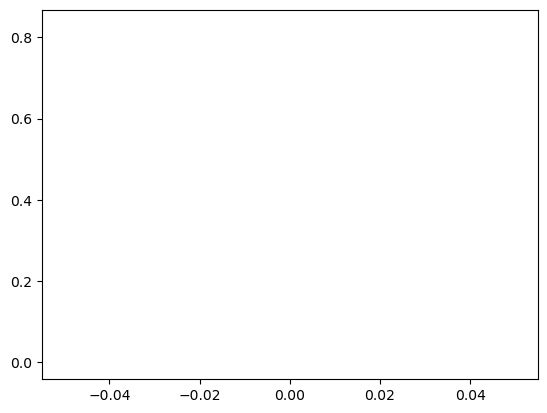

  0%|          | 3/1200 [00:00<02:30,  7.95it/s]

Epoch 1/1200 - loss: 0.8264742394288381, f1: 0.0


  1%|          | 10/1200 [00:02<06:41,  2.96it/s]

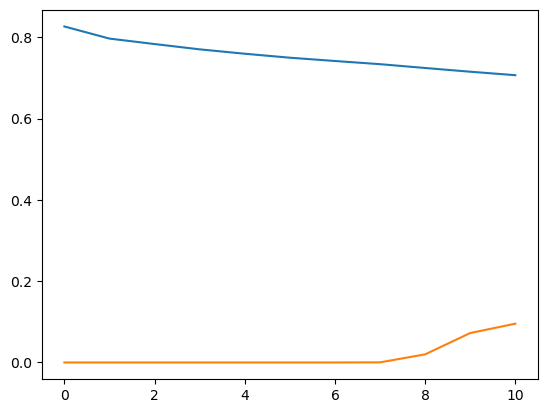

Epoch 11/1200 - loss: 0.7066392997900645, f1: 0.09543532979059832


  2%|▏         | 20/1200 [00:07<08:53,  2.21it/s]

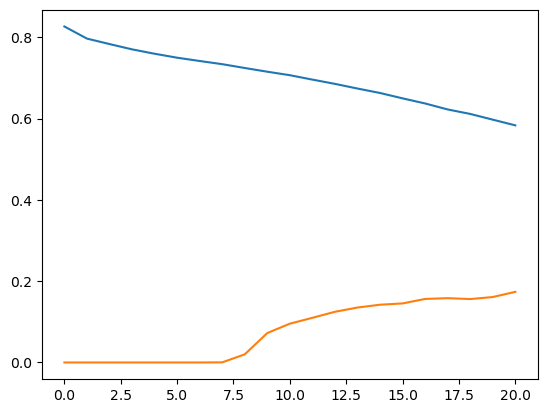

Epoch 21/1200 - loss: 0.583279937505722, f1: 0.17375076780312732


  2%|▎         | 30/1200 [00:10<03:45,  5.18it/s]

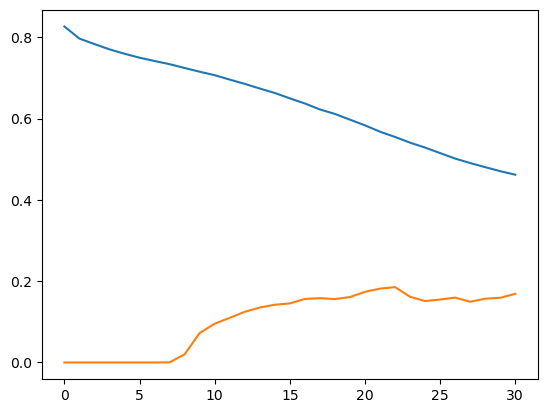

  3%|▎         | 33/1200 [00:10<02:49,  6.90it/s]

Epoch 31/1200 - loss: 0.46187830964724225, f1: 0.16885857996161768


  3%|▎         | 39/1200 [00:11<02:01,  9.54it/s]

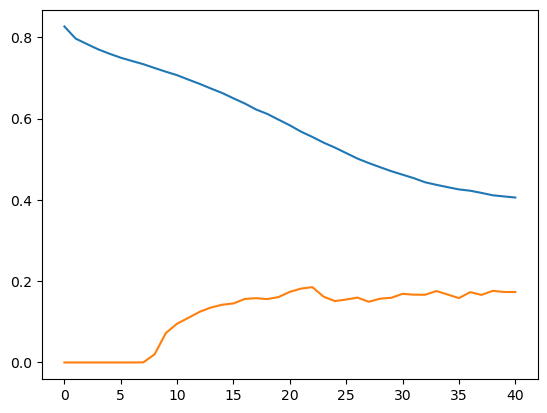

  3%|▎         | 41/1200 [00:11<02:14,  8.59it/s]

Epoch 41/1200 - loss: 0.40574848651885986, f1: 0.17326388083272853


  4%|▍         | 50/1200 [00:13<02:30,  7.64it/s]

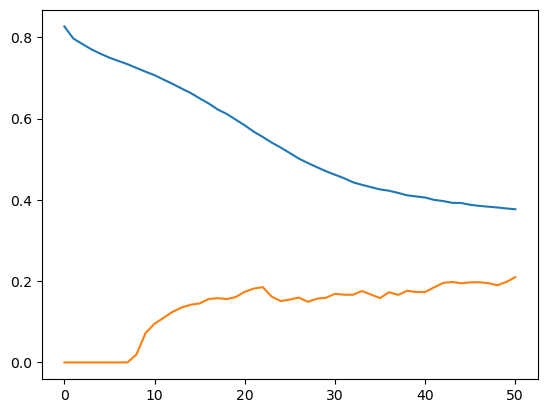

Epoch 51/1200 - loss: 0.37682852149009705, f1: 0.2098321836113013


  5%|▍         | 59/1200 [00:15<04:42,  4.04it/s]

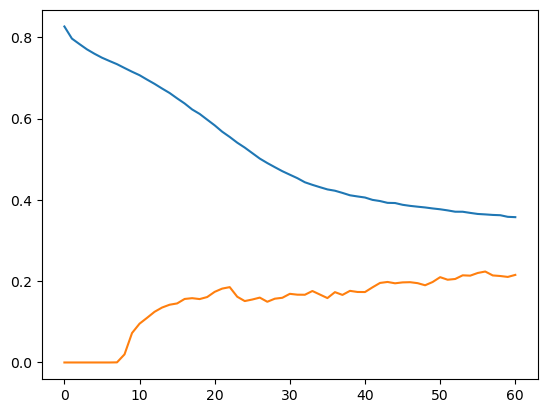

  5%|▌         | 61/1200 [00:16<03:52,  4.90it/s]

Epoch 61/1200 - loss: 0.35746539135773975, f1: 0.2154334496989881


  6%|▌         | 70/1200 [00:17<02:43,  6.90it/s]

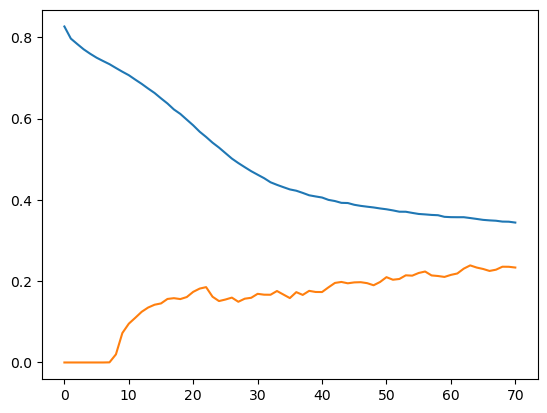

Epoch 71/1200 - loss: 0.34413035213947296, f1: 0.2335278365375118


  7%|▋         | 80/1200 [00:20<04:15,  4.39it/s]

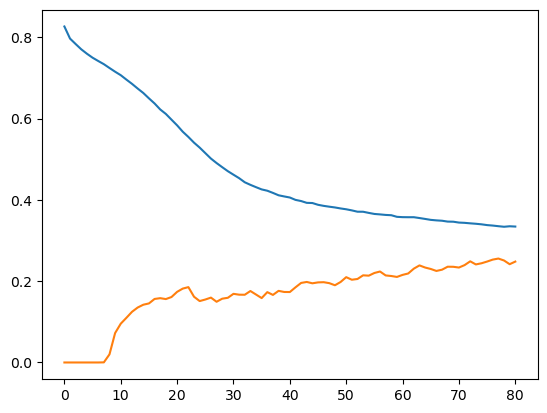

  7%|▋         | 81/1200 [00:20<03:53,  4.80it/s]

Epoch 81/1200 - loss: 0.33433111508687335, f1: 0.24817742024290693


  8%|▊         | 90/1200 [00:23<05:15,  3.52it/s]

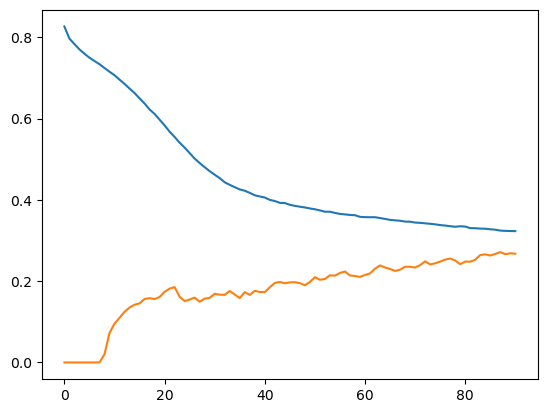

  8%|▊         | 91/1200 [00:23<04:40,  3.96it/s]

Epoch 91/1200 - loss: 0.3230770329634349, f1: 0.26754959422890645


  8%|▊         | 100/1200 [00:26<05:35,  3.28it/s]

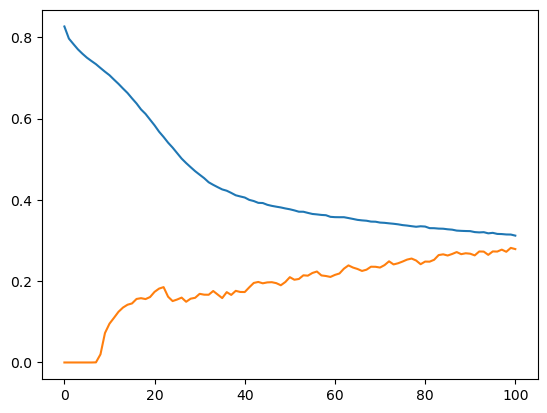

  9%|▊         | 103/1200 [00:26<03:46,  4.85it/s]

Epoch 101/1200 - loss: 0.31202442944049835, f1: 0.2788987796369234


  9%|▉         | 110/1200 [00:29<06:44,  2.70it/s]

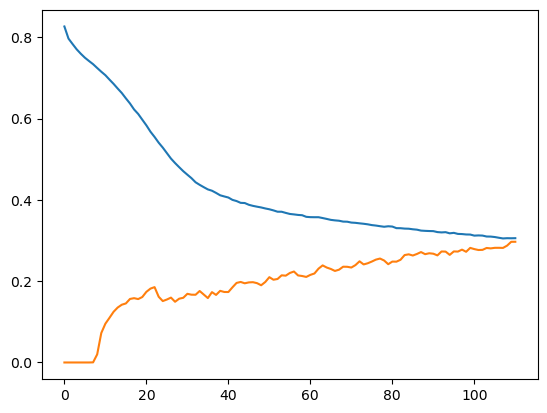

Epoch 111/1200 - loss: 0.3057364970445633, f1: 0.29691503888747706


 10%|▉         | 119/1200 [00:31<03:34,  5.04it/s]

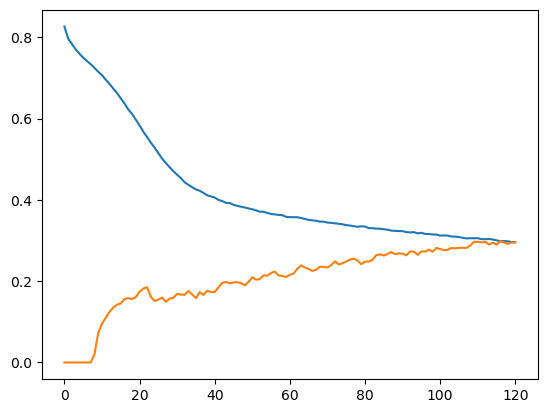

 10%|█         | 122/1200 [00:31<02:48,  6.40it/s]

Epoch 121/1200 - loss: 0.29599736382563907, f1: 0.2954352232143918


 11%|█         | 130/1200 [00:33<03:38,  4.90it/s]

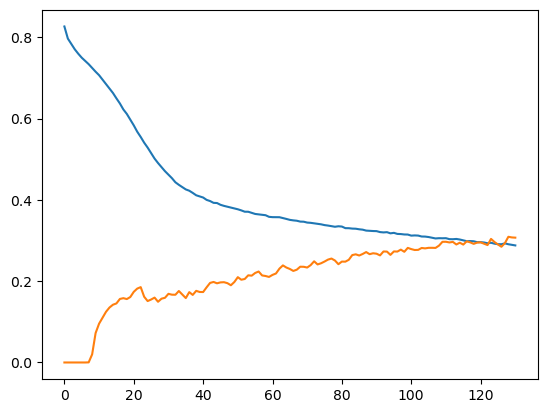

 11%|█         | 131/1200 [00:33<03:25,  5.21it/s]

Epoch 131/1200 - loss: 0.28793539355198544, f1: 0.30703103530147435


 12%|█▏        | 139/1200 [00:35<03:23,  5.22it/s]

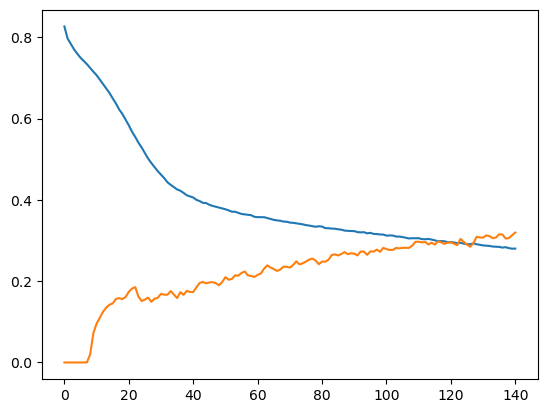

Epoch 141/1200 - loss: 0.28019629915555316, f1: 0.31953381810149317


 12%|█▏        | 149/1200 [00:37<04:03,  4.32it/s]

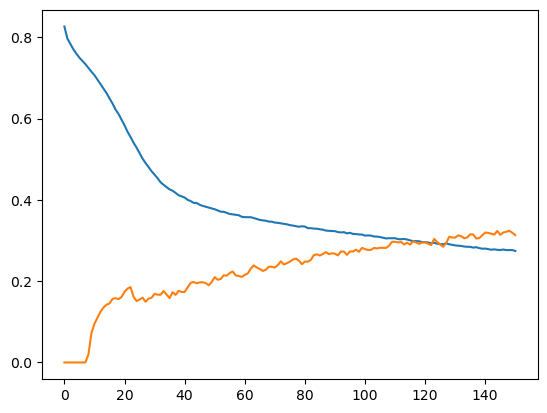

 13%|█▎        | 153/1200 [00:38<02:51,  6.12it/s]

Epoch 151/1200 - loss: 0.2743414292732875, f1: 0.3133605521986471


 13%|█▎        | 160/1200 [00:39<02:23,  7.23it/s]

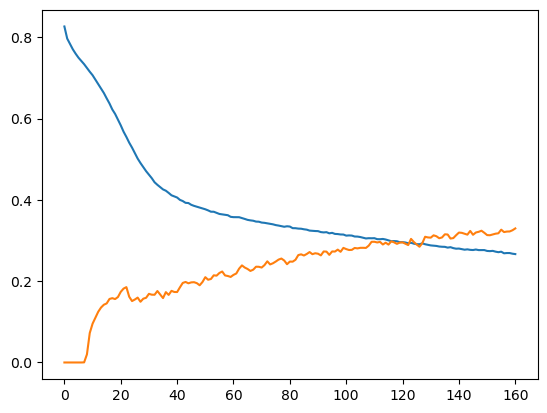

Epoch 161/1200 - loss: 0.26659246285756427, f1: 0.32972764878535454


 14%|█▍        | 170/1200 [00:41<02:41,  6.37it/s]

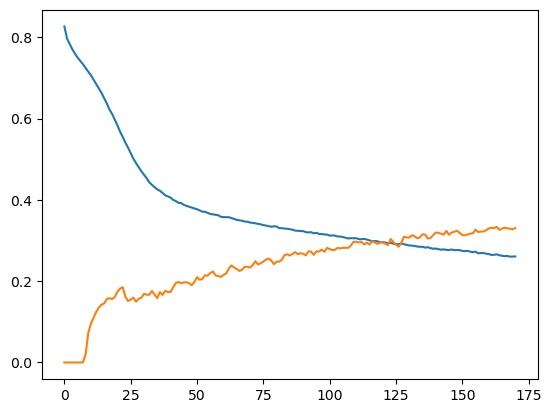

 14%|█▍        | 173/1200 [00:42<02:16,  7.55it/s]

Epoch 171/1200 - loss: 0.26083047191301983, f1: 0.33072795420227963


 15%|█▍        | 179/1200 [00:42<01:36, 10.56it/s]

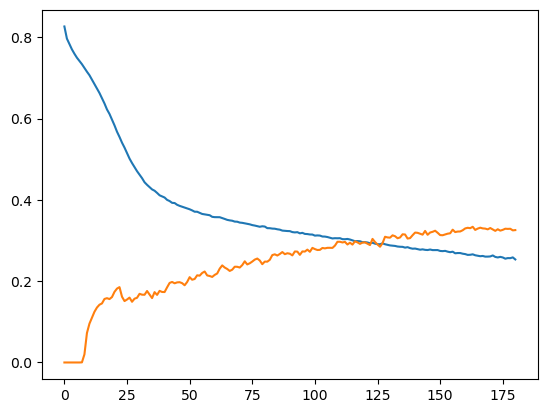

 15%|█▌        | 183/1200 [00:42<01:36, 10.58it/s]

Epoch 181/1200 - loss: 0.25343939661979675, f1: 0.32563027118003907


 16%|█▌        | 189/1200 [00:43<01:26, 11.65it/s]

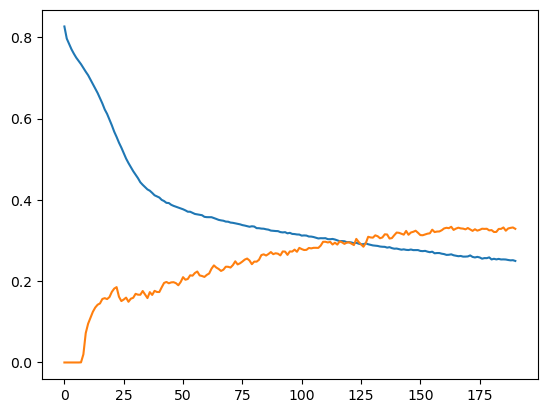

 16%|█▌        | 191/1200 [00:43<01:32, 10.88it/s]

Epoch 191/1200 - loss: 0.24976087113221487, f1: 0.3287537575319972


 17%|█▋        | 200/1200 [00:45<03:27,  4.81it/s]

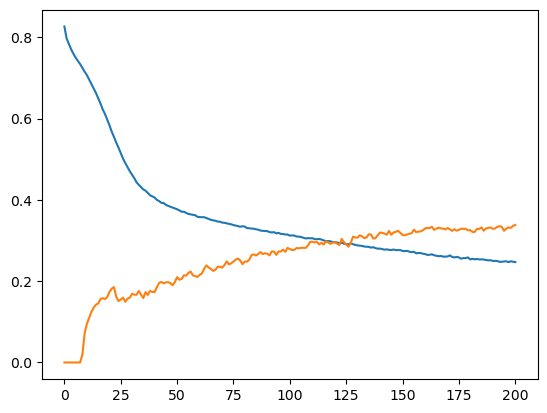

Epoch 201/1200 - loss: 0.24700265377759933, f1: 0.3382846995336233


 17%|█▋        | 209/1200 [00:48<03:17,  5.01it/s]

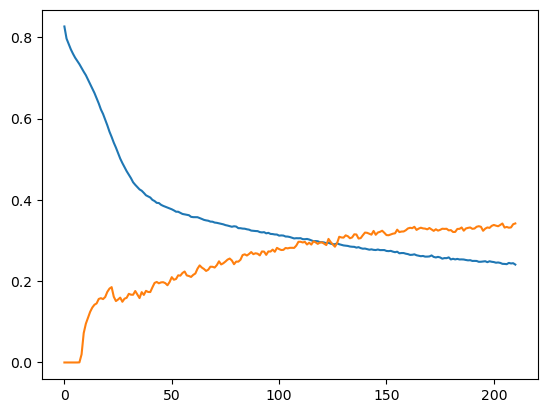

Epoch 211/1200 - loss: 0.2408339555064837, f1: 0.34197806801474273


 18%|█▊        | 219/1200 [00:50<02:18,  7.09it/s]

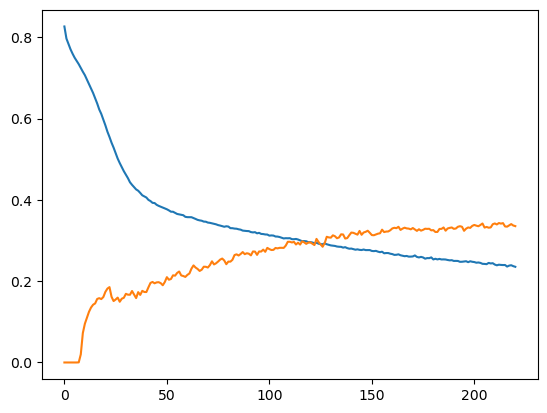

 19%|█▊        | 223/1200 [00:50<02:10,  7.50it/s]

Epoch 221/1200 - loss: 0.235356534520785, f1: 0.3353933944625217


 19%|█▉        | 229/1200 [00:51<01:43,  9.37it/s]

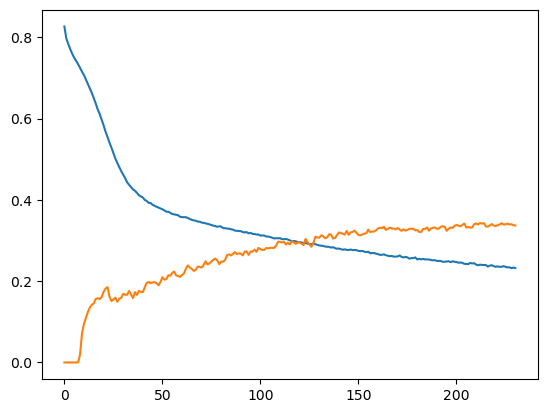

 19%|█▉        | 231/1200 [00:51<01:42,  9.41it/s]

Epoch 231/1200 - loss: 0.23233491679032645, f1: 0.3369449844794947


 20%|█▉        | 239/1200 [00:53<03:07,  5.13it/s]

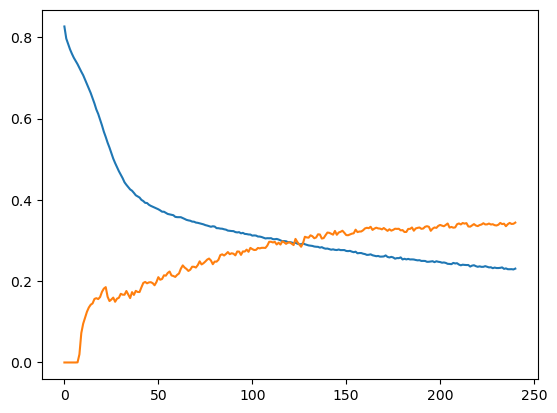

Epoch 241/1200 - loss: 0.23085874815781912, f1: 0.34407767265025


 21%|██        | 249/1200 [00:55<02:59,  5.29it/s]

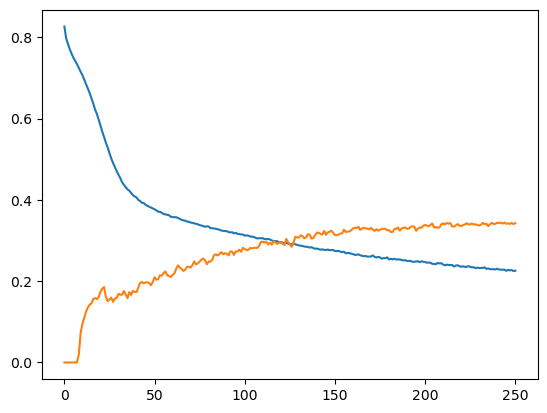

 21%|██        | 253/1200 [00:56<02:09,  7.33it/s]

Epoch 251/1200 - loss: 0.22570076336463293, f1: 0.34270795033400614


 22%|██▏       | 260/1200 [00:57<03:35,  4.35it/s]

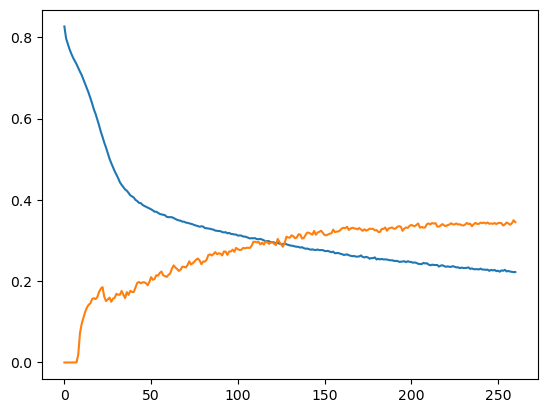

 22%|██▏       | 263/1200 [00:57<02:35,  6.02it/s]

Epoch 261/1200 - loss: 0.22240805129210153, f1: 0.3451857479324737


 22%|██▎       | 270/1200 [00:58<01:33,  9.90it/s]

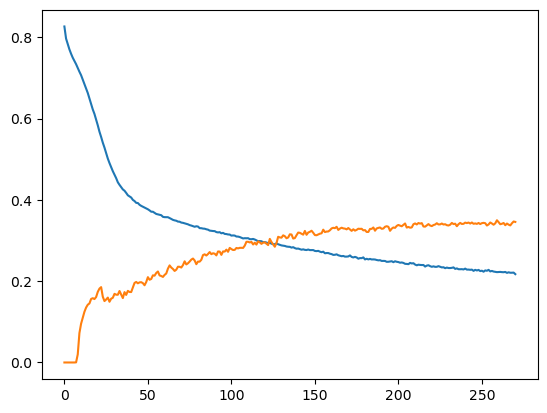

 23%|██▎       | 272/1200 [00:58<01:37,  9.53it/s]

Epoch 271/1200 - loss: 0.21729911615451178, f1: 0.3457311775460136


 23%|██▎       | 279/1200 [01:00<02:06,  7.29it/s]

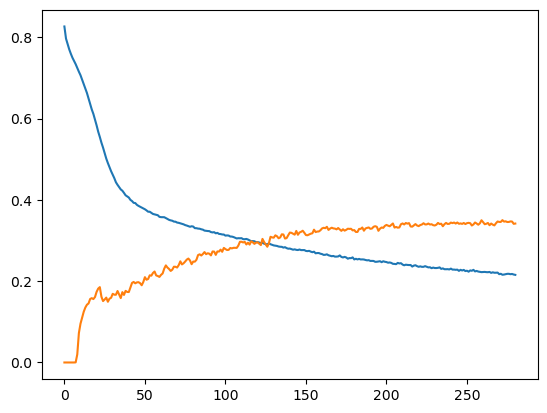

 24%|██▎       | 283/1200 [01:00<01:46,  8.62it/s]

Epoch 281/1200 - loss: 0.21552189687887827, f1: 0.34173154881513434


 24%|██▍       | 289/1200 [01:01<02:29,  6.10it/s]

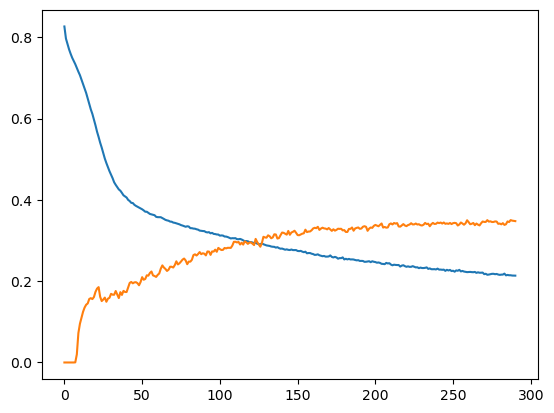

 24%|██▍       | 293/1200 [01:01<01:57,  7.71it/s]

Epoch 291/1200 - loss: 0.2135958050688108, f1: 0.3477206588750067


 25%|██▌       | 300/1200 [01:02<02:06,  7.11it/s]

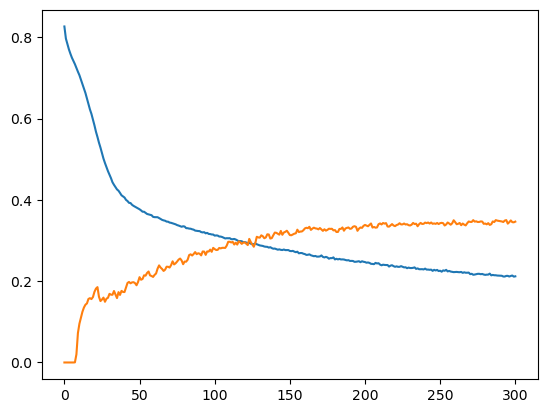

 25%|██▌       | 303/1200 [01:03<01:46,  8.40it/s]

Epoch 301/1200 - loss: 0.21192390223344168, f1: 0.3464444908729673


 26%|██▌       | 309/1200 [01:03<01:21, 10.88it/s]

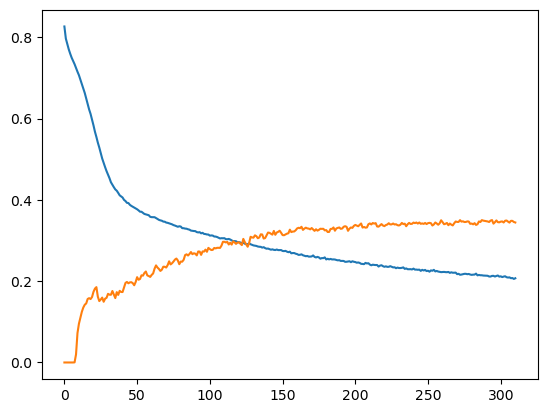

 26%|██▌       | 311/1200 [01:03<01:25, 10.34it/s]

Epoch 311/1200 - loss: 0.20714280505975088, f1: 0.34435246848014267


 27%|██▋       | 319/1200 [01:06<03:25,  4.29it/s]

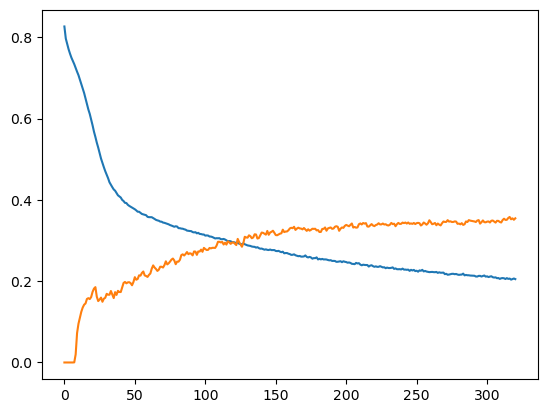

 27%|██▋       | 323/1200 [01:07<02:22,  6.15it/s]

Epoch 321/1200 - loss: 0.20508385449647903, f1: 0.35461980887692124


 27%|██▋       | 329/1200 [01:07<01:43,  8.40it/s]

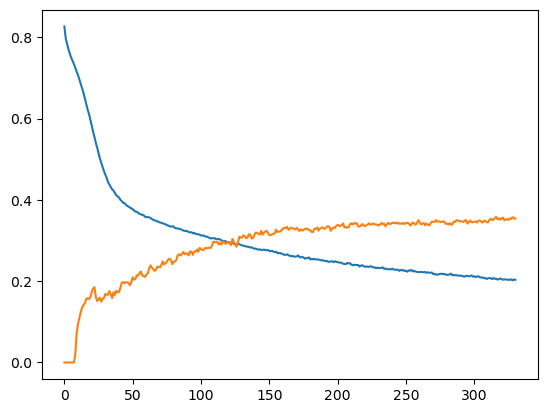

 28%|██▊       | 333/1200 [01:08<01:33,  9.23it/s]

Epoch 331/1200 - loss: 0.2032200569907824, f1: 0.3537297478487641


 28%|██▊       | 339/1200 [01:08<01:49,  7.88it/s]

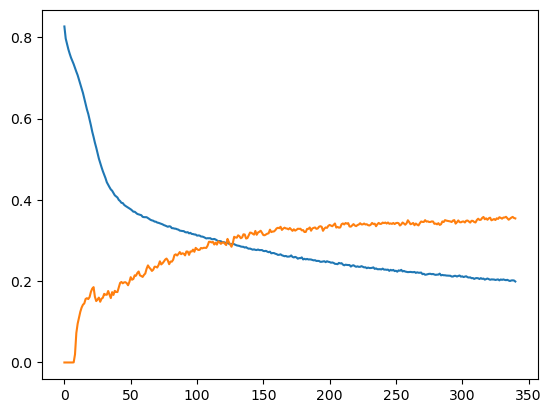

 28%|██▊       | 341/1200 [01:09<01:58,  7.26it/s]

Epoch 341/1200 - loss: 0.19922766337792078, f1: 0.3543363058898473


 29%|██▉       | 349/1200 [01:10<01:43,  8.19it/s]

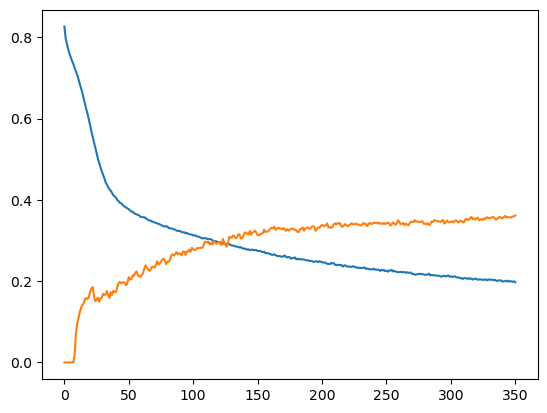

Epoch 351/1200 - loss: 0.1972393443187078, f1: 0.36183711975727073


 30%|███       | 360/1200 [01:12<01:50,  7.58it/s]

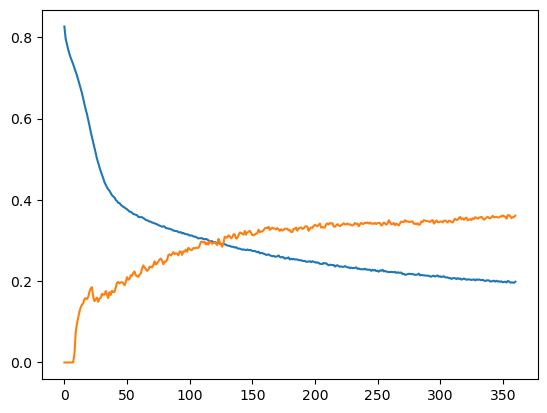

Epoch 361/1200 - loss: 0.19855305552482605, f1: 0.36090006704338995


 31%|███       | 370/1200 [01:13<01:20, 10.32it/s]

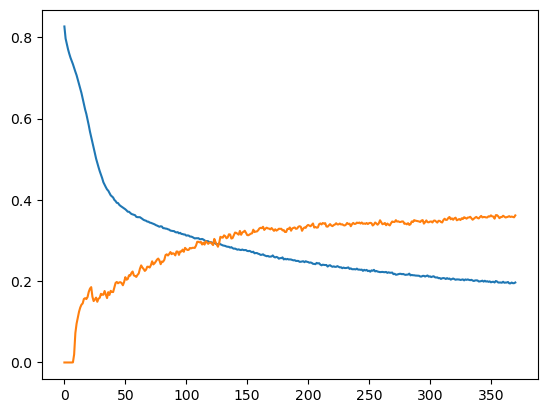

 31%|███       | 372/1200 [01:13<01:23,  9.95it/s]

Epoch 371/1200 - loss: 0.196705291668574, f1: 0.36178636973296535


 32%|███▏      | 380/1200 [01:14<01:54,  7.18it/s]

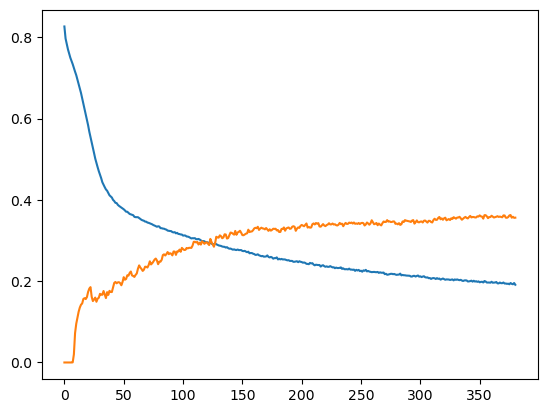

 32%|███▏      | 382/1200 [01:15<01:51,  7.31it/s]

Epoch 381/1200 - loss: 0.19116743902365366, f1: 0.35616635495555304


 32%|███▎      | 390/1200 [01:15<01:31,  8.85it/s]

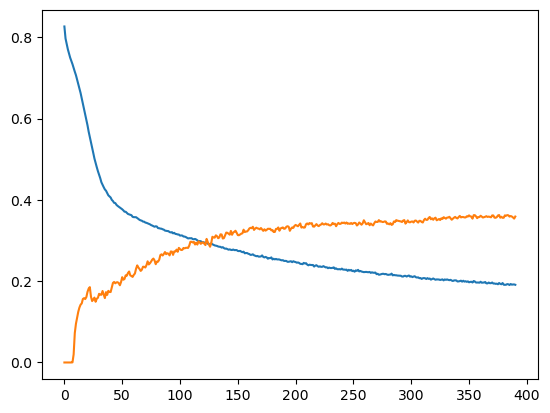

 33%|███▎      | 393/1200 [01:16<01:25,  9.39it/s]

Epoch 391/1200 - loss: 0.19110902398824692, f1: 0.3589480038758063


 33%|███▎      | 399/1200 [01:16<01:13, 10.91it/s]

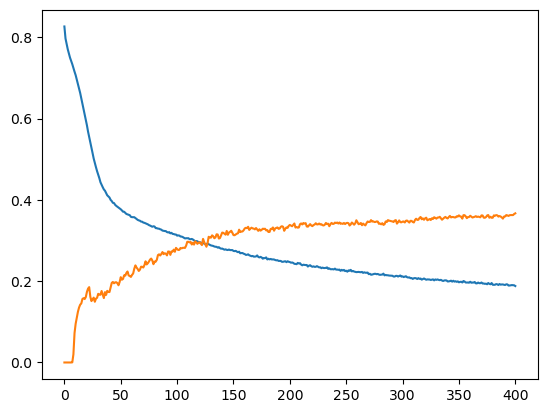

Epoch 401/1200 - loss: 0.1880227526028951, f1: 0.36681609255290415


 34%|███▍      | 410/1200 [01:19<02:20,  5.62it/s]

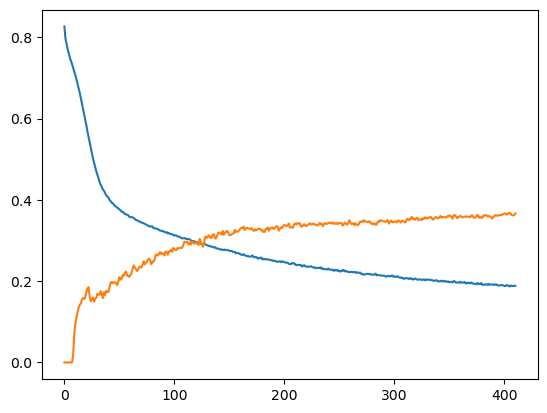

 34%|███▍      | 412/1200 [01:20<02:08,  6.14it/s]

Epoch 411/1200 - loss: 0.18831256280342737, f1: 0.36645011917930104


 35%|███▍      | 419/1200 [01:21<02:23,  5.44it/s]

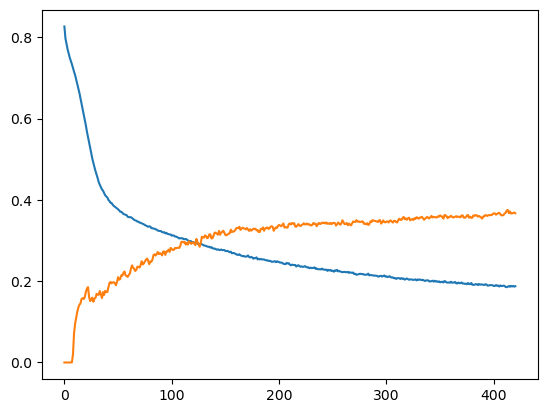

 35%|███▌      | 422/1200 [01:22<01:55,  6.72it/s]

Epoch 421/1200 - loss: 0.18747404714425406, f1: 0.36704098709265415


 36%|███▌      | 430/1200 [01:22<01:15, 10.24it/s]

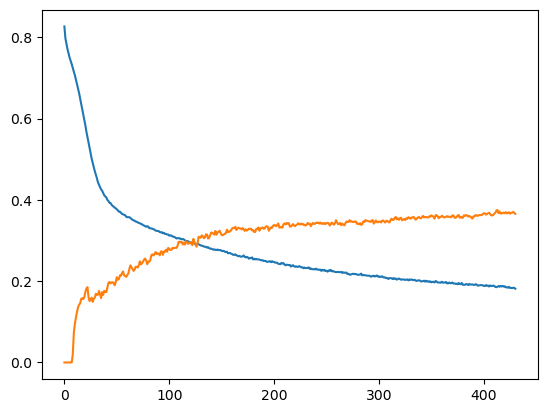

 36%|███▌      | 432/1200 [01:23<01:19,  9.63it/s]

Epoch 431/1200 - loss: 0.18146717796723047, f1: 0.36545550778975827


 37%|███▋      | 440/1200 [01:23<01:10, 10.81it/s]

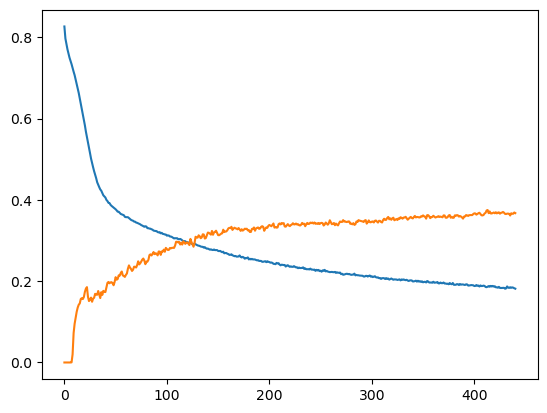

 37%|███▋      | 442/1200 [01:24<01:18,  9.61it/s]

Epoch 441/1200 - loss: 0.1815564682086309, f1: 0.36741563041333125


 37%|███▋      | 449/1200 [01:24<01:14, 10.06it/s]

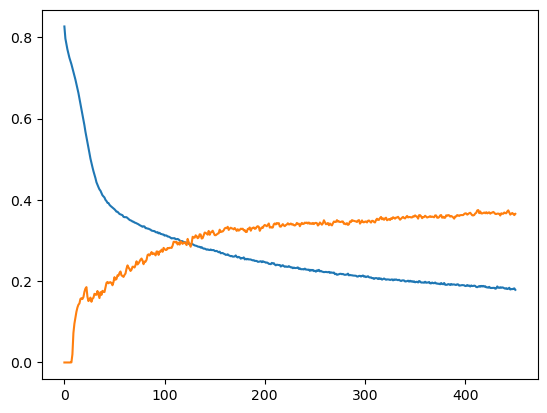

 38%|███▊      | 451/1200 [01:25<01:14, 10.06it/s]

Epoch 451/1200 - loss: 0.17871035635471344, f1: 0.365537457102259


 38%|███▊      | 459/1200 [01:25<01:03, 11.76it/s]

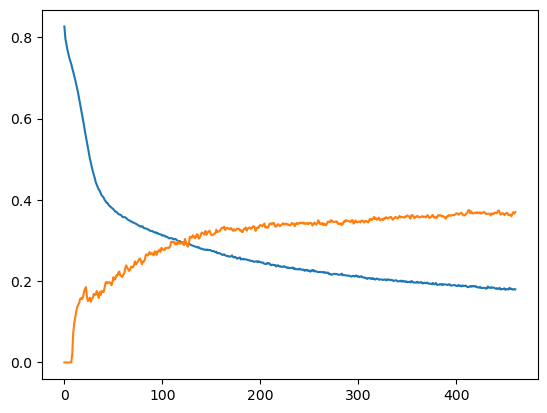

 39%|███▊      | 463/1200 [01:26<01:05, 11.28it/s]

Epoch 461/1200 - loss: 0.1797929455836614, f1: 0.37016360644114654


 39%|███▉      | 469/1200 [01:26<01:18,  9.34it/s]

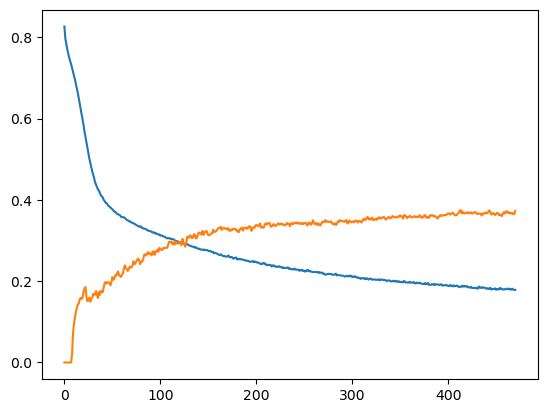

 39%|███▉      | 473/1200 [01:27<01:13,  9.83it/s]

Epoch 471/1200 - loss: 0.1785847544670105, f1: 0.37305342613770853


 40%|███▉      | 479/1200 [01:27<01:02, 11.58it/s]

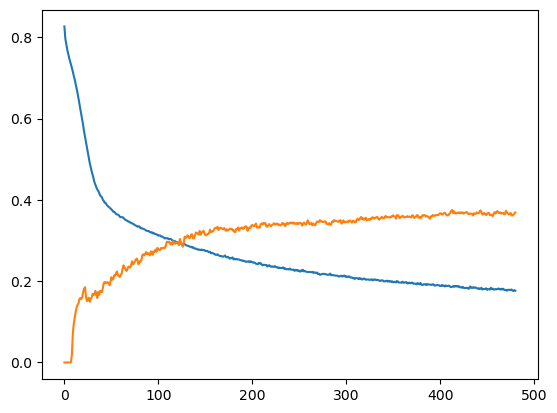

 40%|████      | 483/1200 [01:28<01:04, 11.09it/s]

Epoch 481/1200 - loss: 0.17673812061548233, f1: 0.36902609628033817


 41%|████      | 489/1200 [01:28<00:58, 12.08it/s]

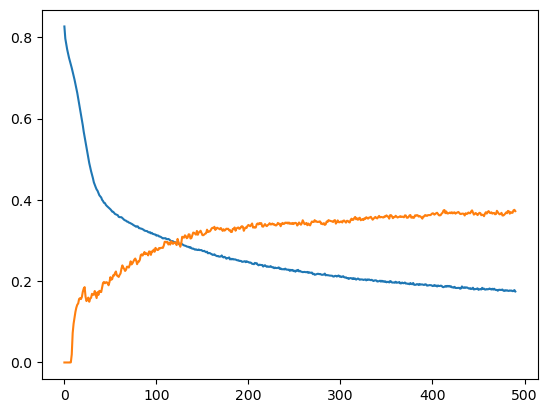

 41%|████      | 492/1200 [01:29<01:50,  6.41it/s]

Epoch 491/1200 - loss: 0.174622875948747, f1: 0.37224095673254143


 42%|████▏     | 499/1200 [01:29<01:10,  9.99it/s]

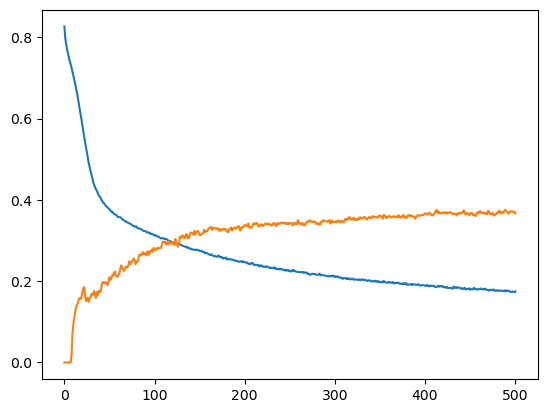

 42%|████▏     | 503/1200 [01:30<01:10,  9.85it/s]

Epoch 501/1200 - loss: 0.17492408057053885, f1: 0.36650863318905913


 42%|████▏     | 509/1200 [01:30<00:57, 12.03it/s]

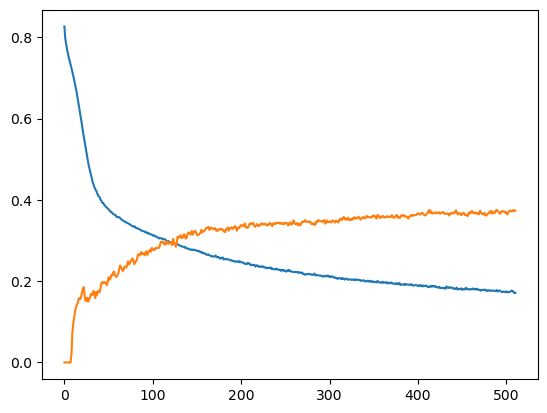

 43%|████▎     | 511/1200 [01:31<01:16,  9.04it/s]

Epoch 511/1200 - loss: 0.1710453083117803, f1: 0.37329855919590443


 43%|████▎     | 519/1200 [01:32<01:16,  8.85it/s]

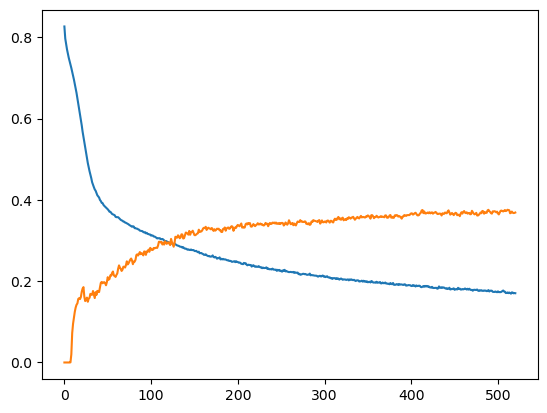

 44%|████▎     | 523/1200 [01:32<01:14,  9.12it/s]

Epoch 521/1200 - loss: 0.17042303830385208, f1: 0.36881155303038726


 44%|████▍     | 529/1200 [01:33<01:01, 10.85it/s]

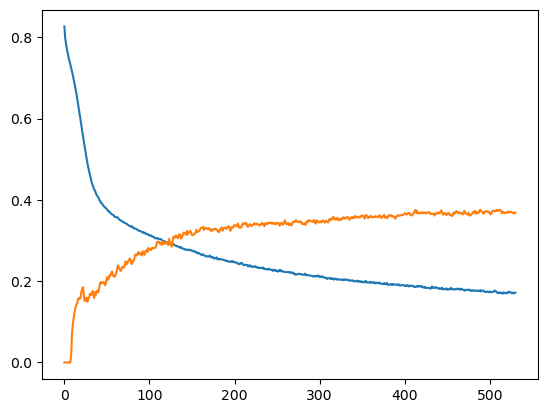

 44%|████▍     | 533/1200 [01:33<01:01, 10.84it/s]

Epoch 531/1200 - loss: 0.1718452995022138, f1: 0.36944476961832196


 45%|████▍     | 539/1200 [01:34<01:39,  6.67it/s]

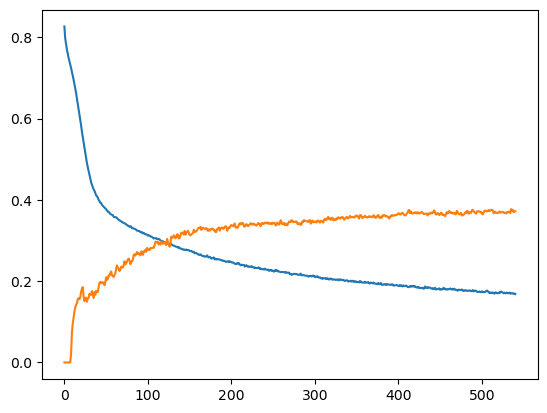

 45%|████▌     | 543/1200 [01:35<01:21,  8.09it/s]

Epoch 541/1200 - loss: 0.16837192326784134, f1: 0.3719754770854598


 46%|████▌     | 549/1200 [01:35<01:07,  9.71it/s]

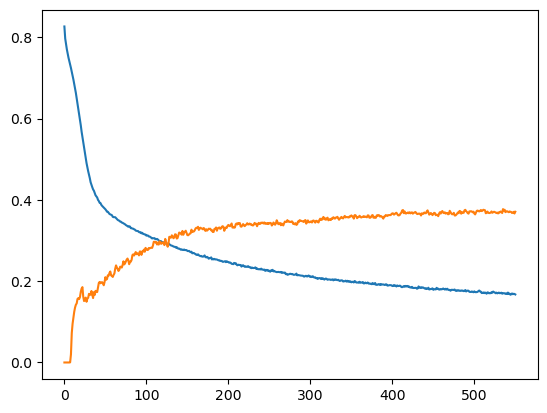

 46%|████▌     | 551/1200 [01:35<01:07,  9.64it/s]

Epoch 551/1200 - loss: 0.1673304264744123, f1: 0.3708022739358623


 47%|████▋     | 560/1200 [01:37<02:27,  4.35it/s]

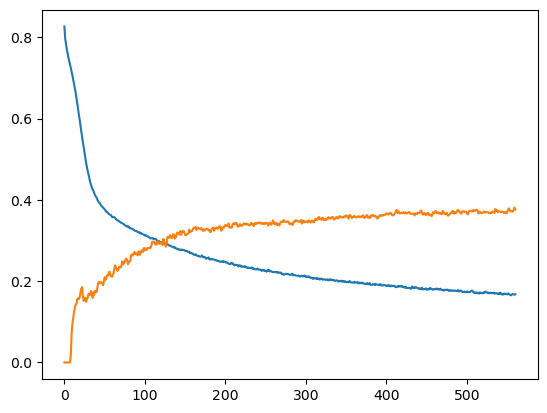

 47%|████▋     | 563/1200 [01:38<01:39,  6.38it/s]

Epoch 561/1200 - loss: 0.1677827388048172, f1: 0.376571040798405


 47%|████▋     | 569/1200 [01:38<01:05,  9.65it/s]

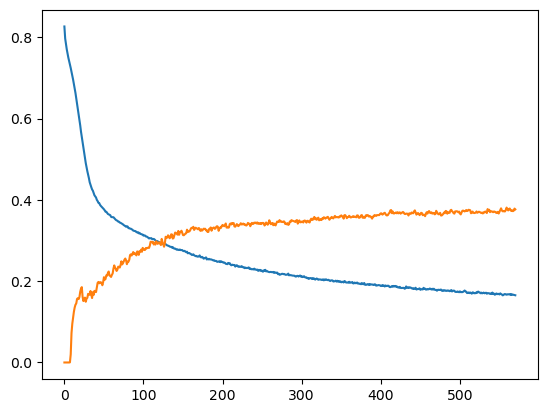

 48%|████▊     | 571/1200 [01:38<01:04,  9.80it/s]

Epoch 571/1200 - loss: 0.16533677279949188, f1: 0.3765801462995324


 48%|████▊     | 579/1200 [01:39<01:15,  8.23it/s]

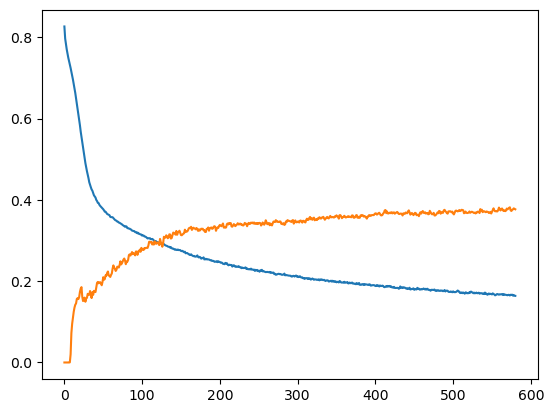

 49%|████▊     | 583/1200 [01:40<01:06,  9.22it/s]

Epoch 581/1200 - loss: 0.16386796782414118, f1: 0.3767971281372416


 49%|████▉     | 589/1200 [01:40<01:02,  9.83it/s]

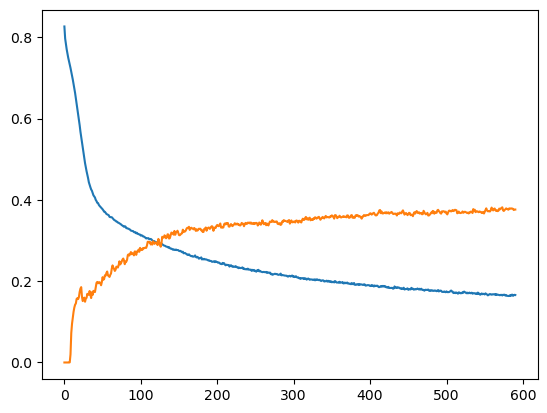

 49%|████▉     | 593/1200 [01:41<01:04,  9.41it/s]

Epoch 591/1200 - loss: 0.16599401831626892, f1: 0.3761887710852593


 50%|████▉     | 599/1200 [01:41<00:53, 11.28it/s]

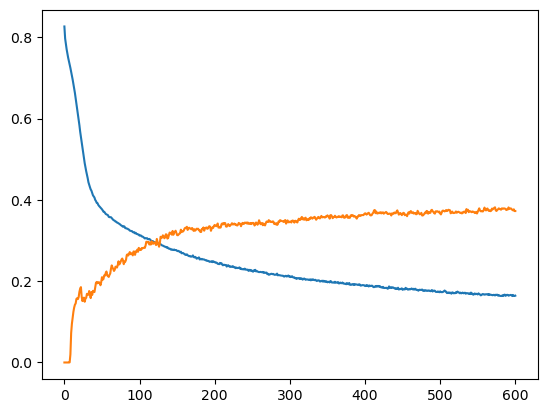

 50%|█████     | 603/1200 [01:42<00:55, 10.72it/s]

Epoch 601/1200 - loss: 0.16430834184090296, f1: 0.37249113562961833


 51%|█████     | 609/1200 [01:42<00:51, 11.50it/s]

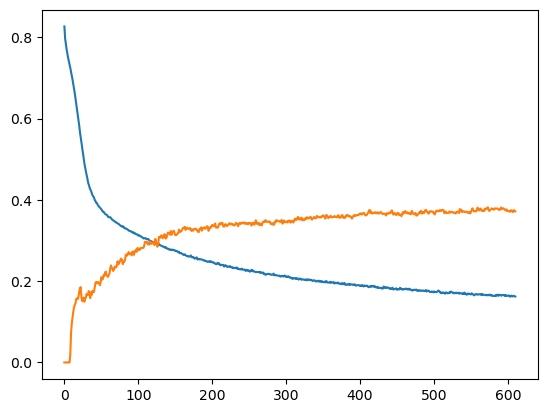

 51%|█████     | 611/1200 [01:43<00:55, 10.59it/s]

Epoch 611/1200 - loss: 0.16221521546443304, f1: 0.3716681856602687


 52%|█████▏    | 619/1200 [01:43<00:53, 10.90it/s]

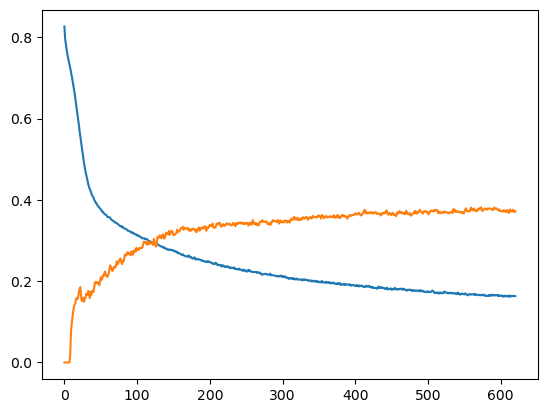

 52%|█████▏    | 623/1200 [01:44<00:55, 10.36it/s]

Epoch 621/1200 - loss: 0.1631768743197123, f1: 0.37177626572558603


 52%|█████▏    | 629/1200 [01:44<00:46, 12.28it/s]

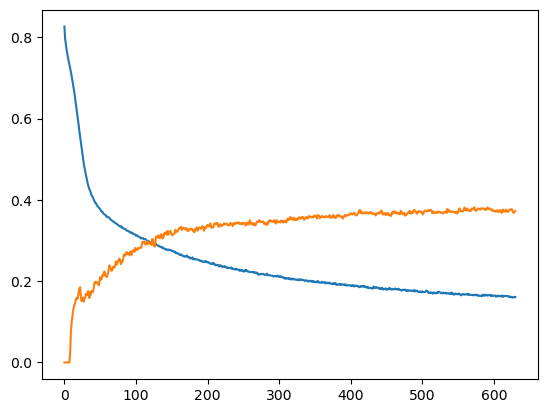

 53%|█████▎    | 633/1200 [01:45<00:52, 10.85it/s]

Epoch 631/1200 - loss: 0.16095524032910666, f1: 0.37229973858366994


 53%|█████▎    | 639/1200 [01:45<00:52, 10.72it/s]

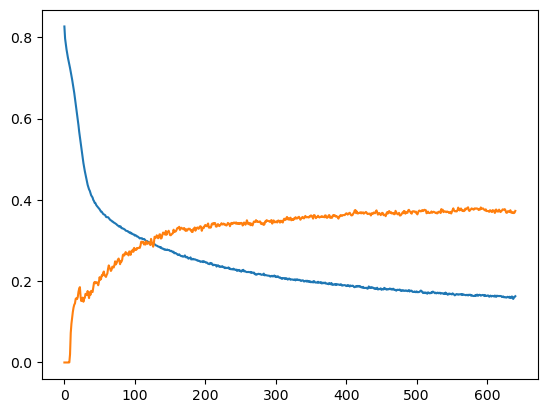

 54%|█████▎    | 643/1200 [01:46<00:58,  9.55it/s]

Epoch 641/1200 - loss: 0.1630339448650678, f1: 0.3728088110105052


 54%|█████▍    | 649/1200 [01:46<00:50, 10.92it/s]

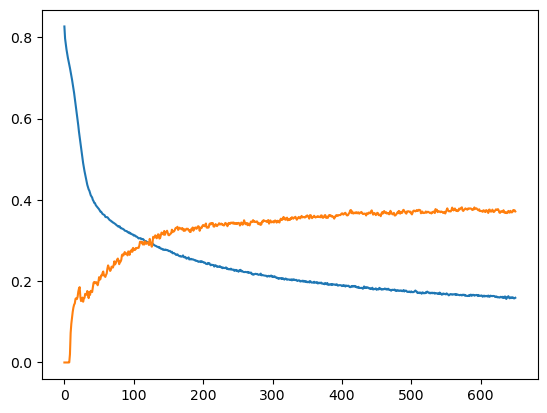

 54%|█████▍    | 651/1200 [01:46<00:52, 10.44it/s]

Epoch 651/1200 - loss: 0.159114437798659, f1: 0.37148382994213247


 55%|█████▍    | 659/1200 [01:47<00:47, 11.49it/s]

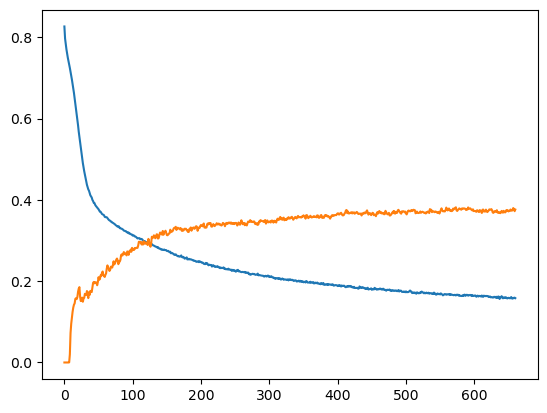

 55%|█████▌    | 663/1200 [01:48<00:54,  9.91it/s]

Epoch 661/1200 - loss: 0.15828565756479898, f1: 0.3762114013144967


 56%|█████▌    | 669/1200 [01:48<00:47, 11.20it/s]

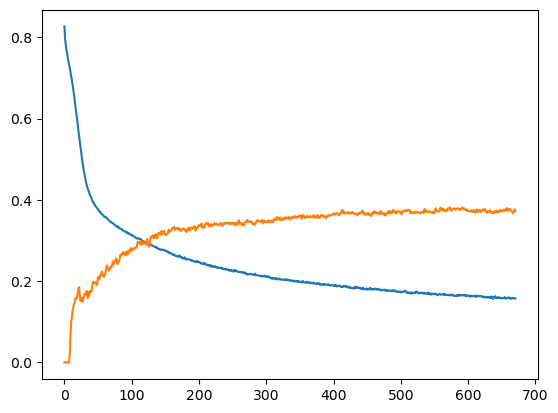

 56%|█████▌    | 673/1200 [01:49<00:55,  9.43it/s]

Epoch 671/1200 - loss: 0.15718649824460348, f1: 0.37174163045564457


 57%|█████▋    | 679/1200 [01:49<00:46, 11.13it/s]

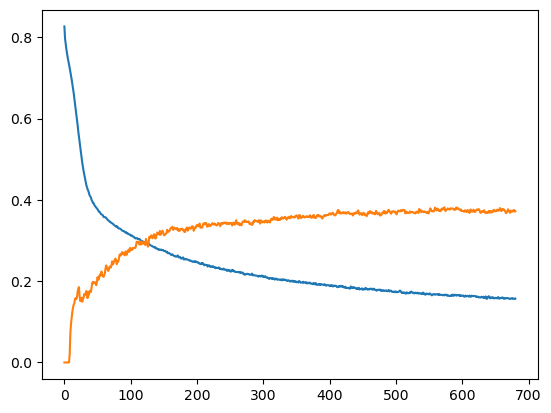

 57%|█████▋    | 681/1200 [01:49<00:51, 10.05it/s]

Epoch 681/1200 - loss: 0.15699156373739243, f1: 0.3718272445648859


 57%|█████▋    | 689/1200 [01:50<00:45, 11.12it/s]

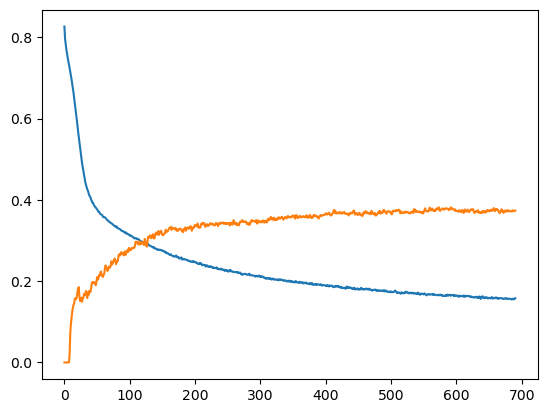

 58%|█████▊    | 693/1200 [01:50<00:46, 10.84it/s]

Epoch 691/1200 - loss: 0.15792792538801828, f1: 0.373565103250276


 58%|█████▊    | 699/1200 [01:51<00:50,  9.97it/s]

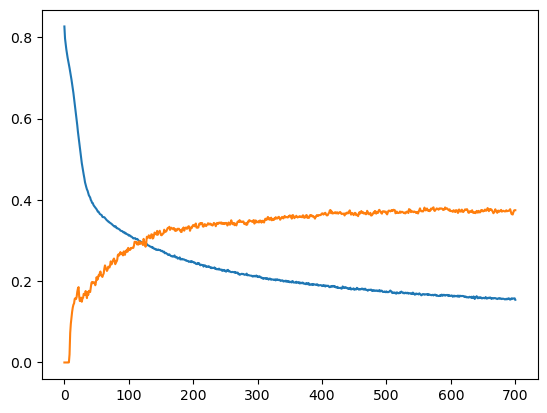

 58%|█████▊    | 701/1200 [01:51<00:50,  9.86it/s]

Epoch 701/1200 - loss: 0.15419994046290716, f1: 0.37457231043105876


 59%|█████▉    | 709/1200 [01:52<00:44, 11.09it/s]

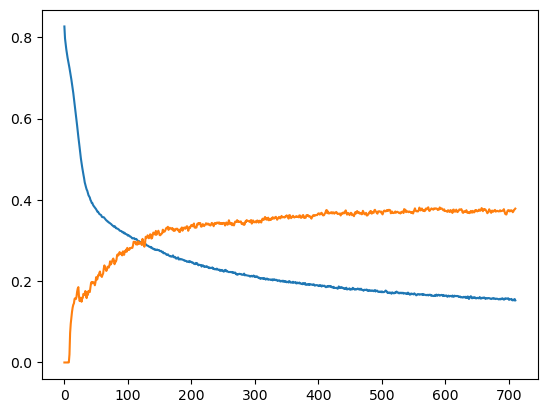

 59%|█████▉    | 713/1200 [01:52<00:46, 10.58it/s]

Epoch 711/1200 - loss: 0.15270648896694183, f1: 0.3784753361601465


 60%|█████▉    | 719/1200 [01:53<00:40, 11.80it/s]

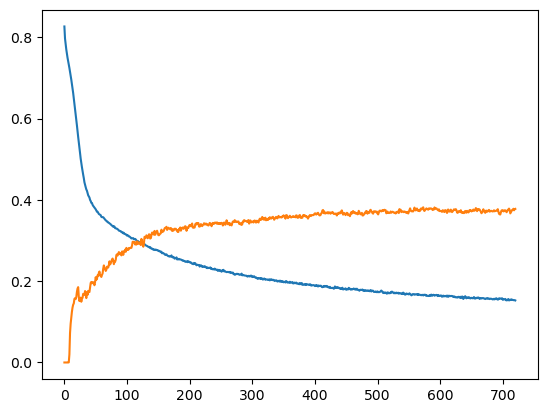

 60%|██████    | 723/1200 [01:53<00:43, 10.92it/s]

Epoch 721/1200 - loss: 0.15264308700958887, f1: 0.37781134054819476


 61%|██████    | 729/1200 [01:54<00:46, 10.17it/s]

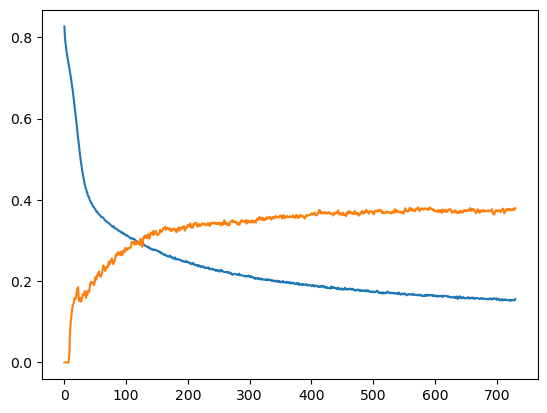

 61%|██████    | 733/1200 [01:54<00:43, 10.84it/s]

Epoch 731/1200 - loss: 0.15574264526367188, f1: 0.37945049770127737


 62%|██████▏   | 739/1200 [01:55<00:41, 11.04it/s]

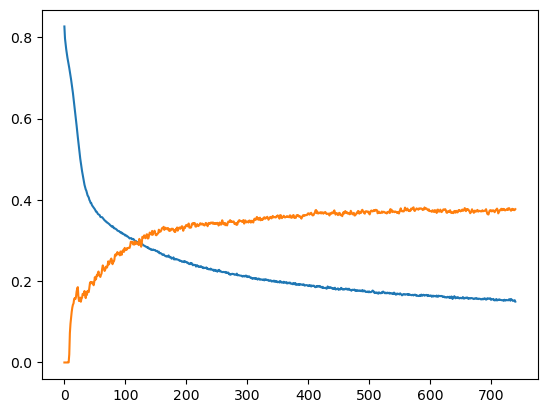

 62%|██████▏   | 743/1200 [01:55<00:42, 10.81it/s]

Epoch 741/1200 - loss: 0.14970430731773376, f1: 0.37714296458916274


 62%|██████▏   | 749/1200 [01:56<00:38, 11.79it/s]

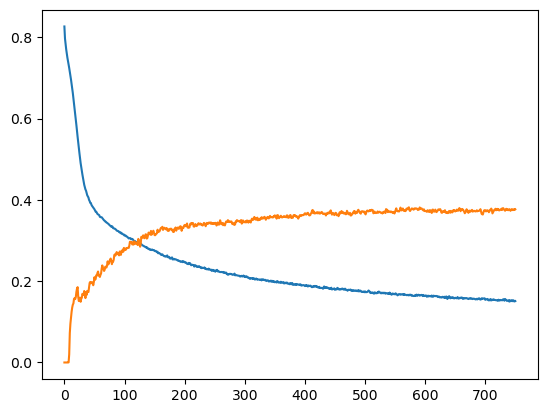

 63%|██████▎   | 751/1200 [01:56<00:45,  9.98it/s]

Epoch 751/1200 - loss: 0.15098976095517477, f1: 0.37669829148877176


 63%|██████▎   | 759/1200 [01:57<00:41, 10.74it/s]

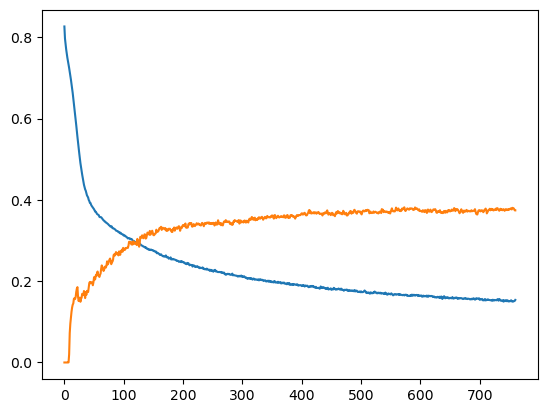

 64%|██████▎   | 763/1200 [01:57<00:40, 10.80it/s]

Epoch 761/1200 - loss: 0.15384338547786078, f1: 0.37409824741388176


 64%|██████▍   | 769/1200 [01:58<00:38, 11.20it/s]

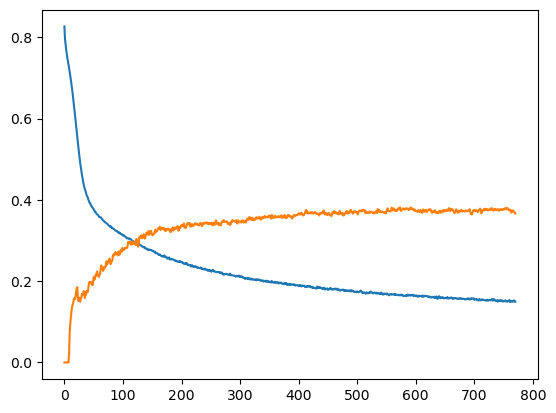

 64%|██████▍   | 771/1200 [01:58<00:40, 10.67it/s]

Epoch 771/1200 - loss: 0.14934301873048147, f1: 0.36609320503070997


 65%|██████▍   | 779/1200 [01:59<00:38, 10.94it/s]

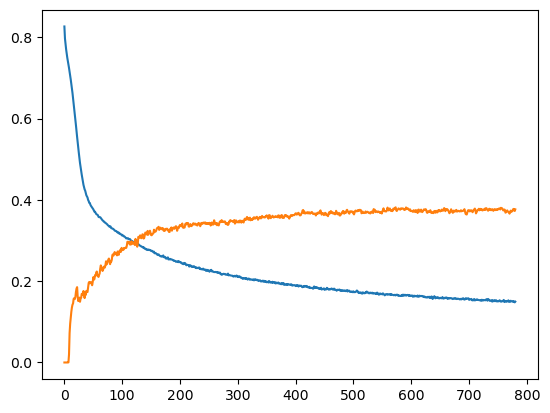

 65%|██████▌   | 781/1200 [01:59<00:42,  9.90it/s]

Epoch 781/1200 - loss: 0.14967913553118706, f1: 0.37660952696914196


 66%|██████▌   | 789/1200 [02:00<00:42,  9.78it/s]

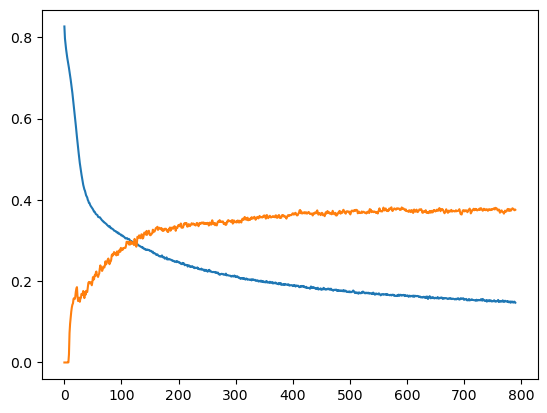

 66%|██████▌   | 793/1200 [02:00<00:40, 10.16it/s]

Epoch 791/1200 - loss: 0.14702302093307176, f1: 0.37551059053096425


 67%|██████▋   | 799/1200 [02:02<01:15,  5.33it/s]

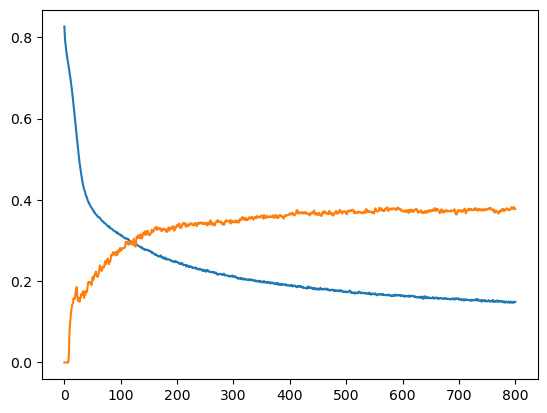

 67%|██████▋   | 803/1200 [02:02<00:52,  7.61it/s]

Epoch 801/1200 - loss: 0.149112148831288, f1: 0.37723994406139794


 67%|██████▋   | 809/1200 [02:03<00:59,  6.52it/s]

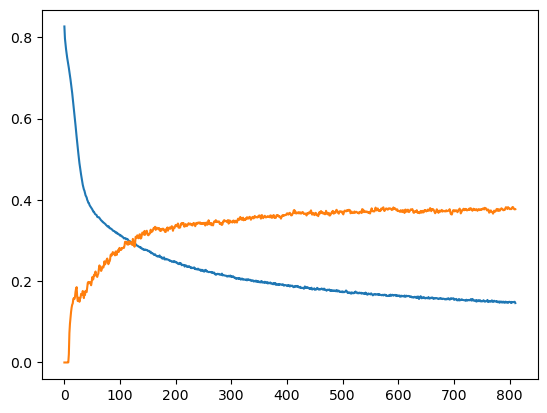

 68%|██████▊   | 812/1200 [02:04<00:52,  7.45it/s]

Epoch 811/1200 - loss: 0.14620990057786307, f1: 0.3770104349100861


 68%|██████▊   | 820/1200 [02:04<00:34, 11.00it/s]

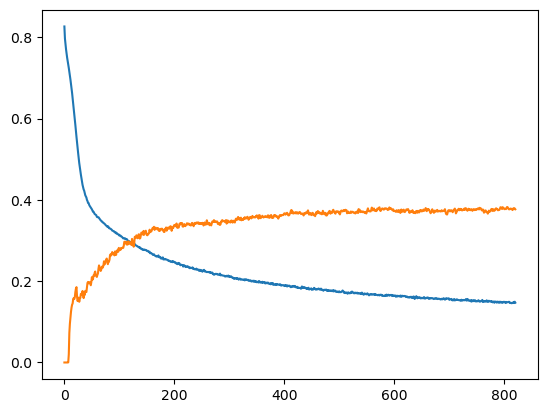

 68%|██████▊   | 822/1200 [02:04<00:35, 10.56it/s]

Epoch 821/1200 - loss: 0.14706992482145628, f1: 0.37683453231964725


 69%|██████▉   | 830/1200 [02:05<00:32, 11.36it/s]

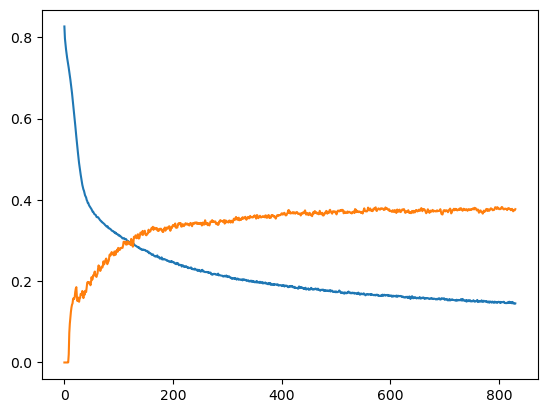

 69%|██████▉   | 832/1200 [02:05<00:41,  8.96it/s]

Epoch 831/1200 - loss: 0.1453463758031527, f1: 0.37712790894824655


 70%|███████   | 840/1200 [02:06<00:32, 10.96it/s]

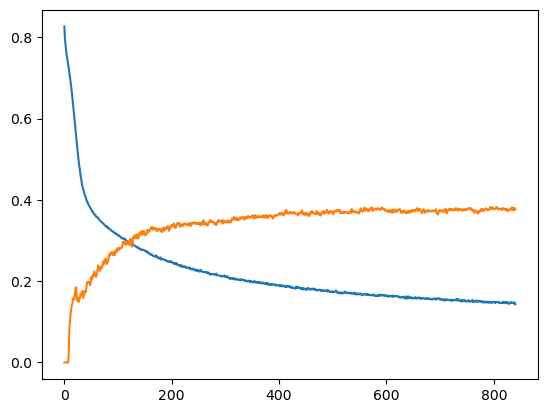

 70%|███████   | 842/1200 [02:06<00:34, 10.41it/s]

Epoch 841/1200 - loss: 0.14324824512004852, f1: 0.3761315458550683


 71%|███████   | 850/1200 [02:07<00:30, 11.52it/s]

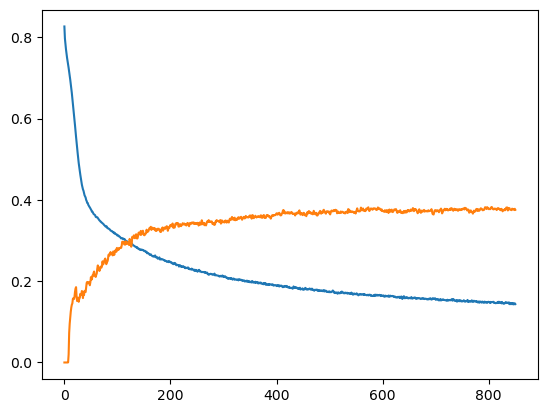

 71%|███████   | 852/1200 [02:07<00:32, 10.87it/s]

Epoch 851/1200 - loss: 0.14360020806392035, f1: 0.375603052087754


 72%|███████▏  | 860/1200 [02:08<00:28, 11.87it/s]

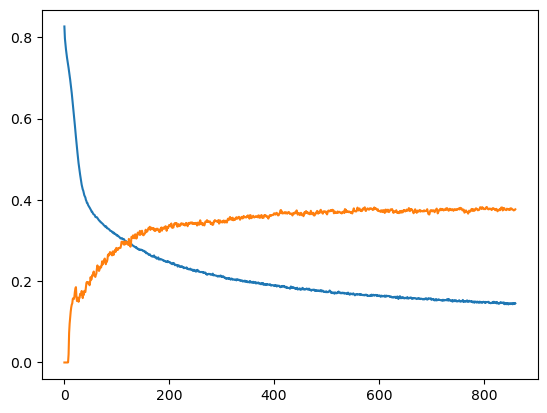

 72%|███████▏  | 862/1200 [02:08<00:30, 11.21it/s]

Epoch 861/1200 - loss: 0.14538008719682693, f1: 0.37680577709141827


 72%|███████▎  | 870/1200 [02:09<00:28, 11.45it/s]

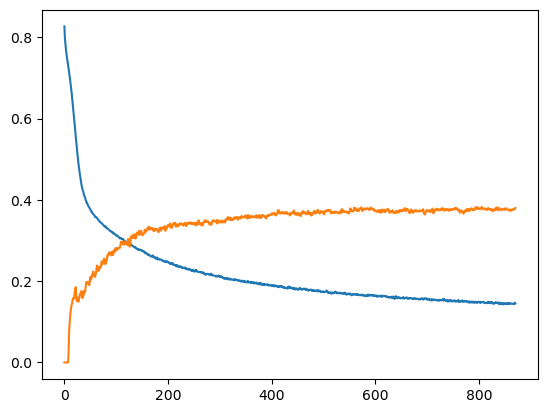

Epoch 871/1200 - loss: 0.14550561333696047, f1: 0.3799980755217043


 73%|███████▎  | 879/1200 [02:10<00:34,  9.27it/s]

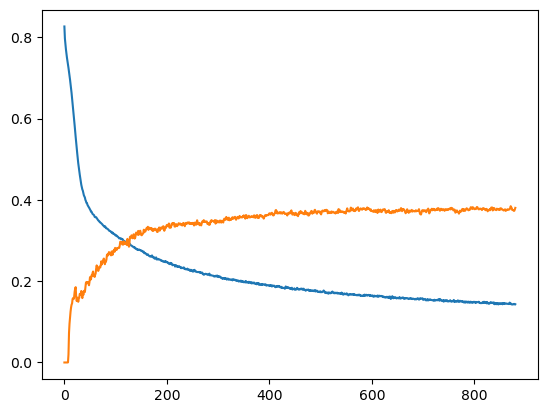

 74%|███████▎  | 883/1200 [02:11<00:31,  9.94it/s]

Epoch 881/1200 - loss: 0.14328201487660408, f1: 0.38029024302421865


 74%|███████▍  | 889/1200 [02:11<00:30, 10.14it/s]

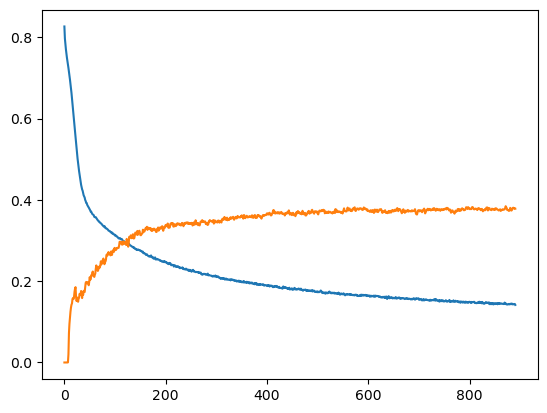

 74%|███████▍  | 893/1200 [02:12<00:30, 10.14it/s]

Epoch 891/1200 - loss: 0.1416131854057312, f1: 0.37824347692998767


 75%|███████▍  | 899/1200 [02:12<00:33,  9.12it/s]

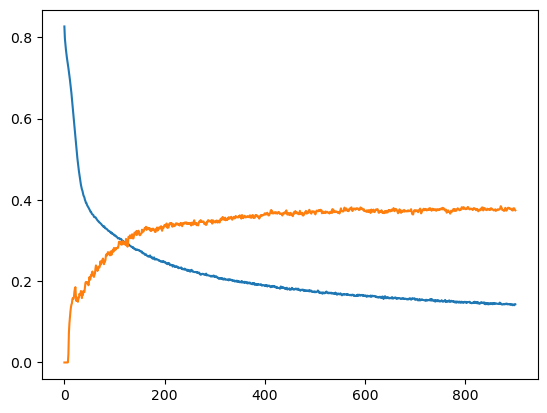

 75%|███████▌  | 903/1200 [02:13<00:31,  9.57it/s]

Epoch 901/1200 - loss: 0.14313621446490288, f1: 0.3742217016342839


 76%|███████▌  | 909/1200 [02:13<00:25, 11.27it/s]

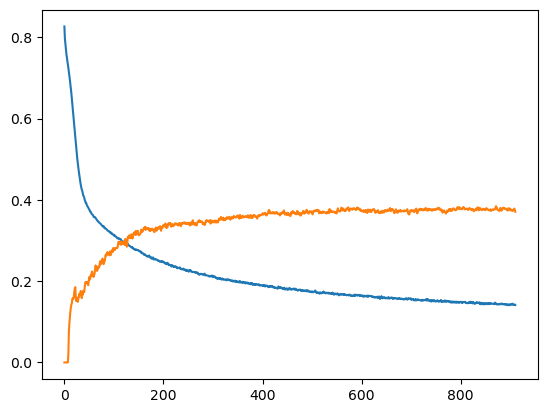

 76%|███████▌  | 913/1200 [02:14<00:27, 10.28it/s]

Epoch 911/1200 - loss: 0.14136937136451402, f1: 0.37077711690570286


 77%|███████▋  | 919/1200 [02:14<00:23, 11.89it/s]

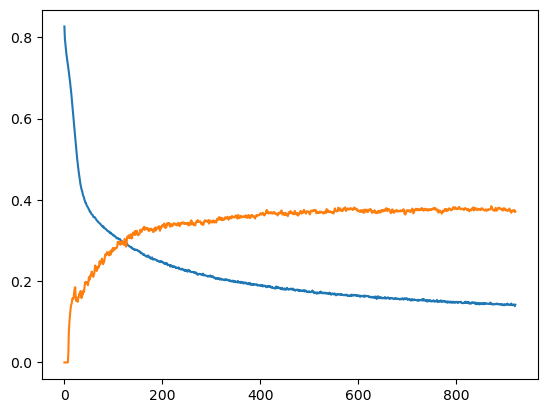

 77%|███████▋  | 923/1200 [02:14<00:26, 10.57it/s]

Epoch 921/1200 - loss: 0.14223832388718924, f1: 0.3708427300341798


 78%|███████▊  | 930/1200 [02:15<00:26, 10.03it/s]

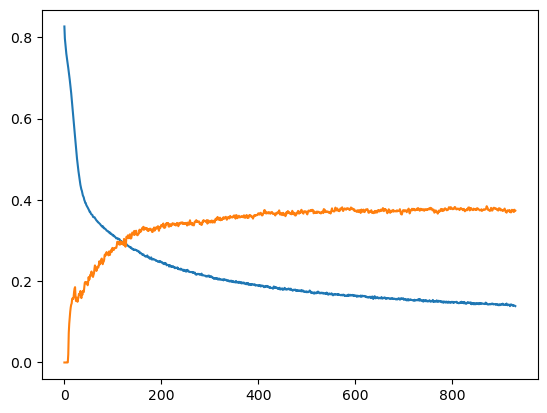

 78%|███████▊  | 932/1200 [02:15<00:27,  9.80it/s]

Epoch 931/1200 - loss: 0.13868031774957976, f1: 0.37339250721378514


 78%|███████▊  | 940/1200 [02:16<00:24, 10.70it/s]

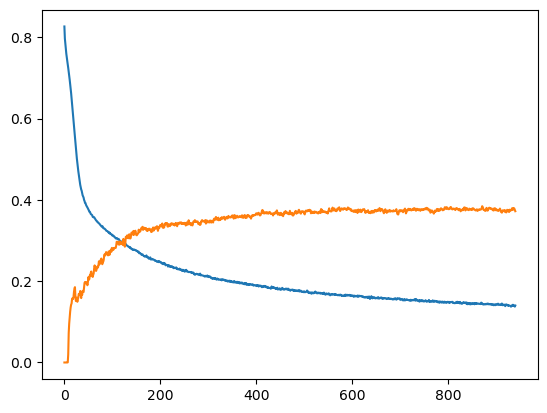

 78%|███████▊  | 942/1200 [02:16<00:25, 10.04it/s]

Epoch 941/1200 - loss: 0.1401349070171515, f1: 0.3720918188028648


 79%|███████▉  | 950/1200 [02:17<00:21, 11.61it/s]

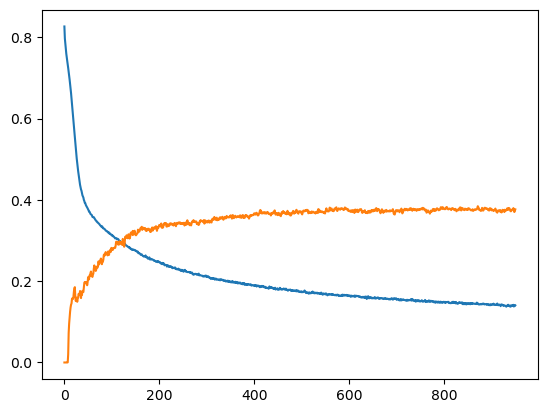

 79%|███████▉  | 952/1200 [02:17<00:23, 10.52it/s]

Epoch 951/1200 - loss: 0.1405130699276924, f1: 0.37658330639190696


 80%|████████  | 960/1200 [02:18<00:20, 11.45it/s]

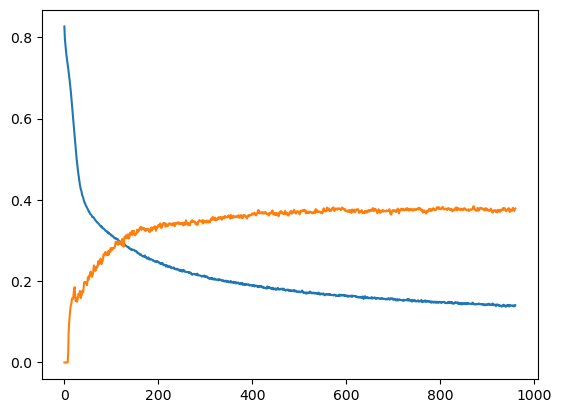

 80%|████████  | 962/1200 [02:18<00:21, 10.93it/s]

Epoch 961/1200 - loss: 0.14071724812189737, f1: 0.37883885993063793


 81%|████████  | 970/1200 [02:19<00:22, 10.42it/s]

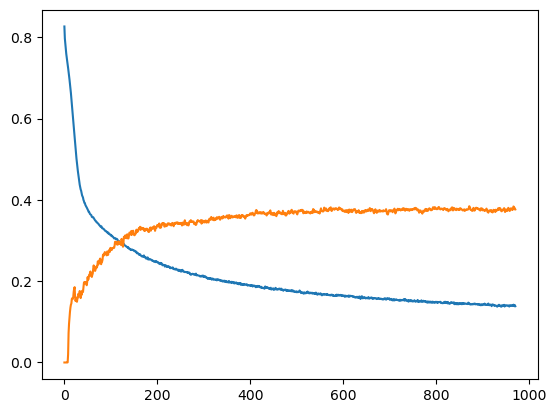

 81%|████████  | 972/1200 [02:19<00:22,  9.96it/s]

Epoch 971/1200 - loss: 0.13834655409057936, f1: 0.37644485270619


 82%|████████▏ | 980/1200 [02:20<00:21, 10.29it/s]

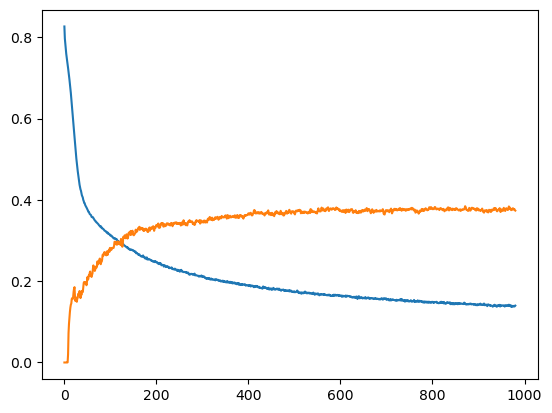

 82%|████████▏ | 982/1200 [02:20<00:22,  9.80it/s]

Epoch 981/1200 - loss: 0.1398642100393772, f1: 0.37357932345284495


 82%|████████▎ | 990/1200 [02:21<00:18, 11.41it/s]

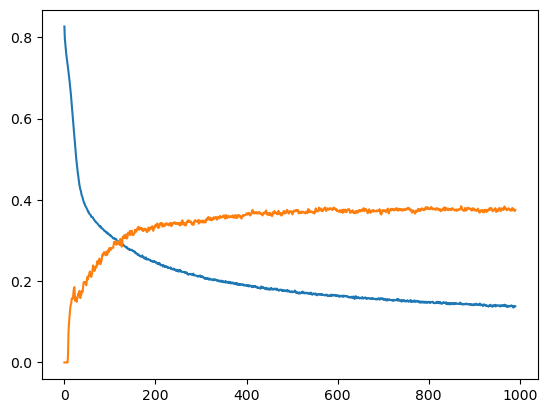

 83%|████████▎ | 992/1200 [02:21<00:19, 10.52it/s]

Epoch 991/1200 - loss: 0.13823856661717096, f1: 0.3753234033749988


 83%|████████▎ | 1000/1200 [02:22<00:17, 11.24it/s]

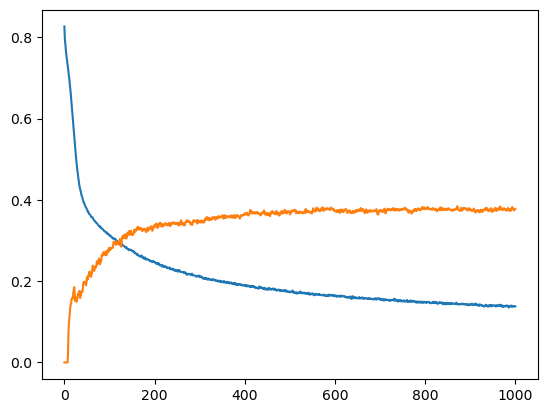

 84%|████████▎ | 1002/1200 [02:22<00:20,  9.80it/s]

Epoch 1001/1200 - loss: 0.1380521592994531, f1: 0.3777996820352007


 84%|████████▍ | 1010/1200 [02:23<00:17, 11.17it/s]

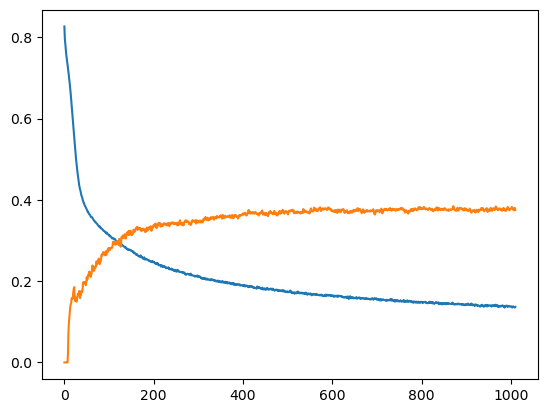

 84%|████████▍ | 1012/1200 [02:23<00:18, 10.22it/s]

Epoch 1011/1200 - loss: 0.13666787991921106, f1: 0.3748509896918466


 85%|████████▌ | 1020/1200 [02:24<00:19,  9.22it/s]

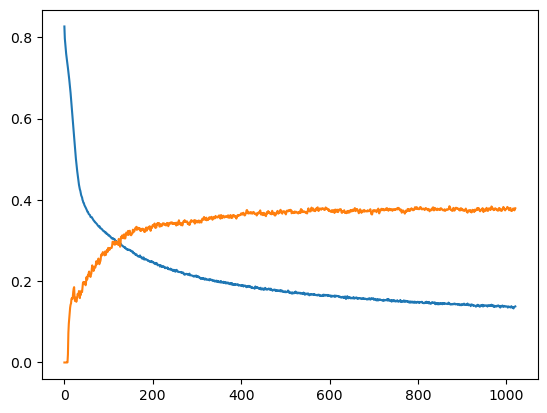

 85%|████████▌ | 1023/1200 [02:24<00:18,  9.37it/s]

Epoch 1021/1200 - loss: 0.13788114984830221, f1: 0.37931229372649533


 86%|████████▌ | 1029/1200 [02:25<00:16, 10.53it/s]

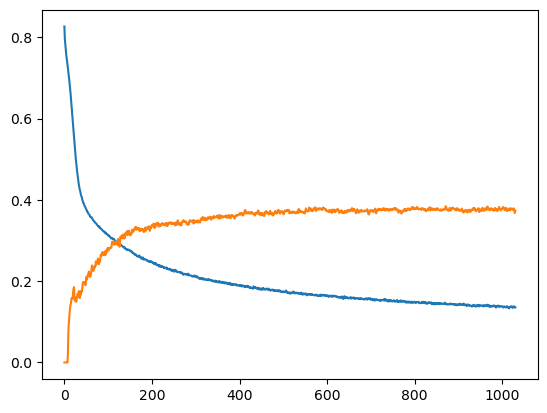

 86%|████████▌ | 1033/1200 [02:25<00:16,  9.95it/s]

Epoch 1031/1200 - loss: 0.13552673906087875, f1: 0.37316013921526214


 87%|████████▋ | 1039/1200 [02:26<00:14, 11.17it/s]

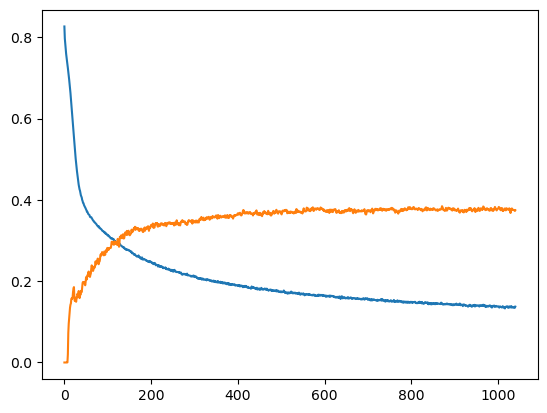

 87%|████████▋ | 1041/1200 [02:26<00:15, 10.44it/s]

Epoch 1041/1200 - loss: 0.13744112104177475, f1: 0.3744624957839341


 87%|████████▋ | 1049/1200 [02:27<00:14, 10.26it/s]

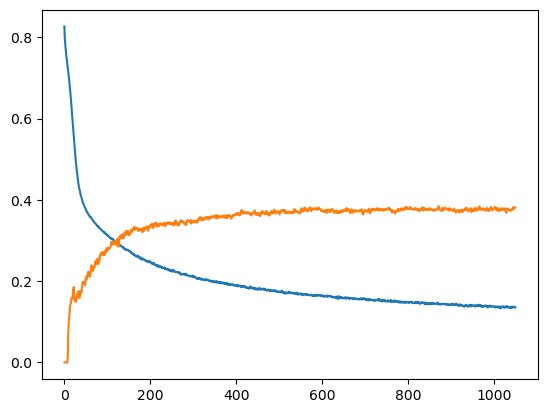

 88%|████████▊ | 1053/1200 [02:27<00:13, 10.58it/s]

Epoch 1051/1200 - loss: 0.13539265096187592, f1: 0.38086410471412346


 88%|████████▊ | 1059/1200 [02:28<00:19,  7.38it/s]

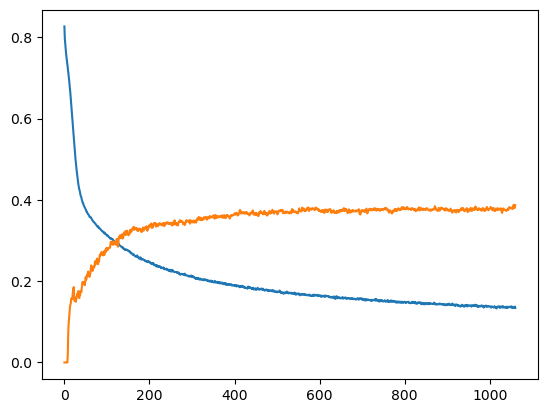

 89%|████████▊ | 1063/1200 [02:29<00:15,  8.64it/s]

Epoch 1061/1200 - loss: 0.13409859935442606, f1: 0.3866882458791072


 89%|████████▉ | 1069/1200 [02:29<00:14,  8.89it/s]

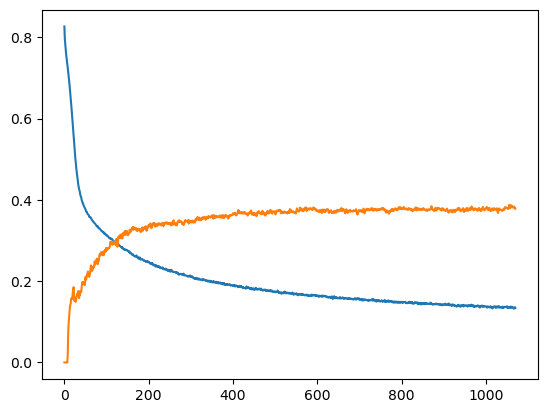

 89%|████████▉ | 1073/1200 [02:30<00:12,  9.77it/s]

Epoch 1071/1200 - loss: 0.1339006225268046, f1: 0.37816414328384484


 90%|████████▉ | 1079/1200 [02:30<00:10, 11.47it/s]

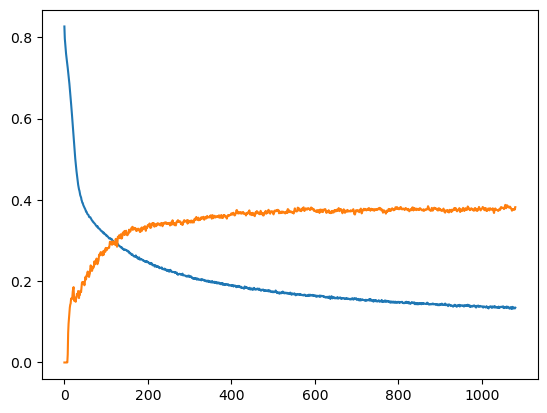

 90%|█████████ | 1083/1200 [02:30<00:10, 10.79it/s]

Epoch 1081/1200 - loss: 0.1348569318652153, f1: 0.3820929974227015


 91%|█████████ | 1089/1200 [02:31<00:10, 10.45it/s]

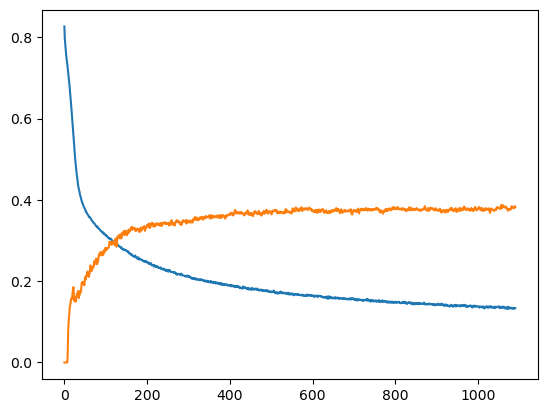

 91%|█████████ | 1093/1200 [02:31<00:09, 10.97it/s]

Epoch 1091/1200 - loss: 0.13361405953764915, f1: 0.38173486292796543


 92%|█████████▏| 1099/1200 [02:32<00:08, 11.49it/s]

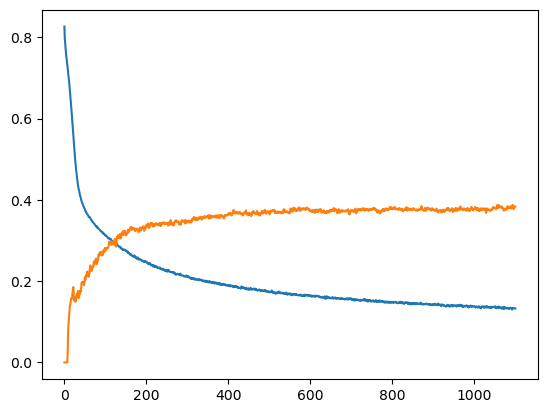

 92%|█████████▏| 1103/1200 [02:32<00:08, 10.98it/s]

Epoch 1101/1200 - loss: 0.13278869539499283, f1: 0.3836174216435311


 92%|█████████▏| 1109/1200 [02:33<00:08, 11.37it/s]

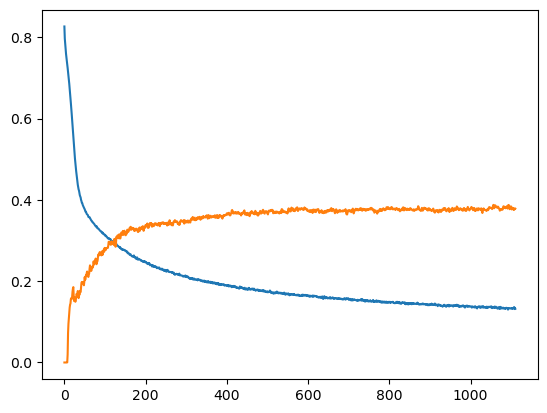

 93%|█████████▎| 1113/1200 [02:33<00:09,  9.08it/s]

Epoch 1111/1200 - loss: 0.13206813484430313, f1: 0.3785084228242481


 93%|█████████▎| 1119/1200 [02:34<00:07, 10.80it/s]

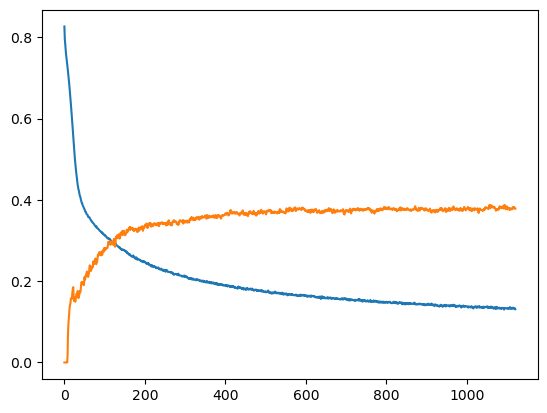

 94%|█████████▎| 1123/1200 [02:34<00:07, 10.70it/s]

Epoch 1121/1200 - loss: 0.13100646063685417, f1: 0.3783132519358221


 94%|█████████▍| 1129/1200 [02:35<00:06, 10.89it/s]

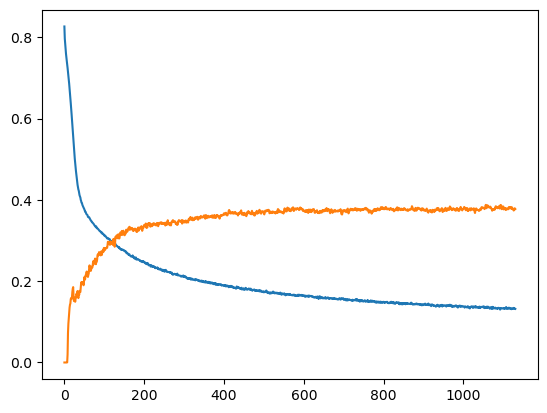

 94%|█████████▍| 1133/1200 [02:35<00:06, 11.02it/s]

Epoch 1131/1200 - loss: 0.1318524293601513, f1: 0.3774163951691744


 95%|█████████▍| 1139/1200 [02:36<00:06, 10.02it/s]

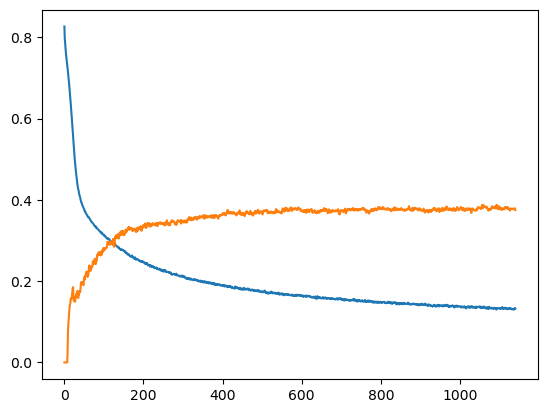

 95%|█████████▌| 1143/1200 [02:36<00:05,  9.85it/s]

Epoch 1141/1200 - loss: 0.13254334777593613, f1: 0.3747733529287164


 96%|█████████▌| 1149/1200 [02:37<00:04, 10.73it/s]

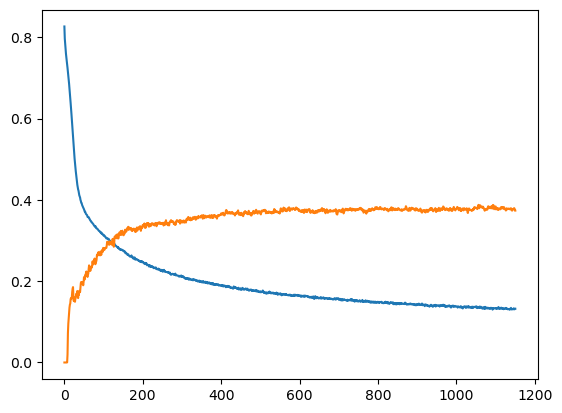

 96%|█████████▌| 1153/1200 [02:37<00:04, 10.31it/s]

Epoch 1151/1200 - loss: 0.13224467386802038, f1: 0.3735966935523581


 97%|█████████▋| 1159/1200 [02:38<00:04, 10.14it/s]

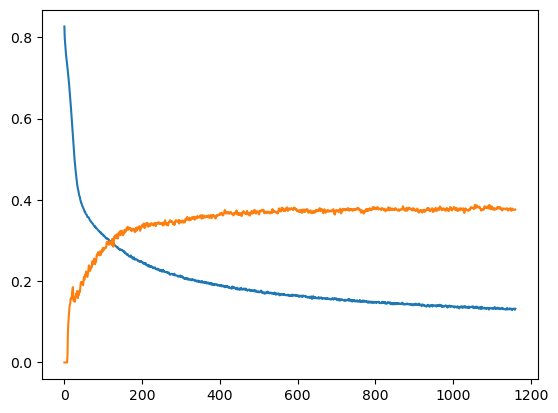

 97%|█████████▋| 1162/1200 [02:38<00:04,  8.28it/s]

Epoch 1161/1200 - loss: 0.13223051403959593, f1: 0.3761692154005204


 97%|█████████▋| 1169/1200 [02:39<00:02, 10.92it/s]

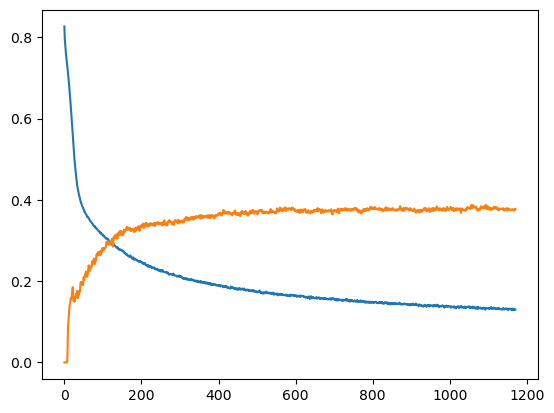

 98%|█████████▊| 1173/1200 [02:39<00:02, 10.79it/s]

Epoch 1171/1200 - loss: 0.1299715315302213, f1: 0.3775859333934969


 98%|█████████▊| 1179/1200 [02:40<00:01, 10.85it/s]

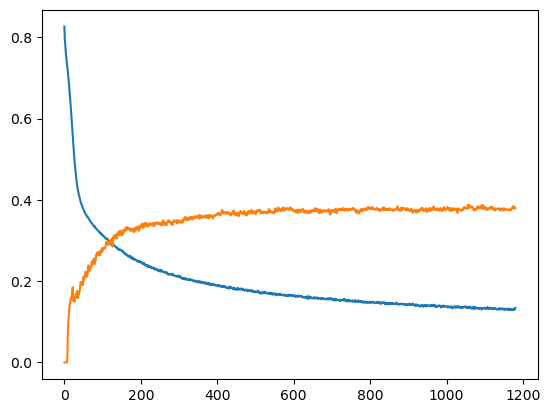

 99%|█████████▊| 1183/1200 [02:40<00:01, 10.70it/s]

Epoch 1181/1200 - loss: 0.13411347071329752, f1: 0.3800984370581083


 99%|█████████▉| 1189/1200 [02:41<00:00, 11.08it/s]

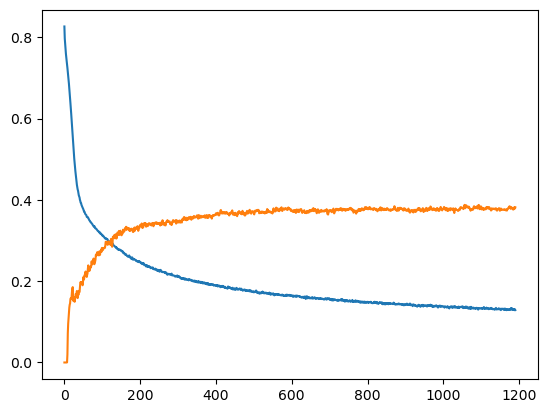

 99%|█████████▉| 1193/1200 [02:41<00:00,  9.47it/s]

Epoch 1191/1200 - loss: 0.12883174791932106, f1: 0.3817595286811235


100%|██████████| 1200/1200 [02:42<00:00,  7.40it/s]


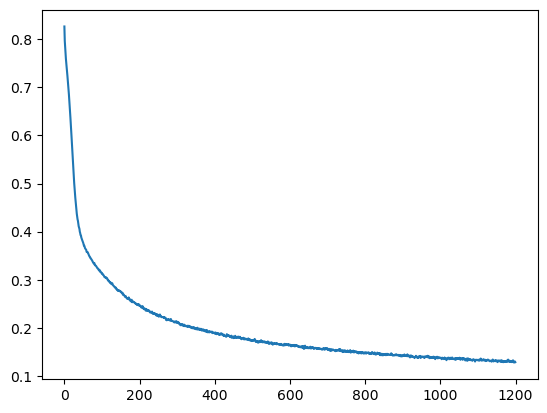

In [13]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1200
losses = []
metrics = []

best_metric = 0

for epoch in tqdm(range(epochs)):

    total_loss = 0
    total_metric = 0
    
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        outputs = torch.where(outputs > 0.75, 1, 0)
        outputs = outputs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()

        total_metric += f1_score(labels, outputs, average="weighted")

    losses.append(total_loss / len(data_loader))
    metrics.append(total_metric / len(val_loader))
    
    if epoch % 10 == 0:
        plt.plot(losses)
        plt.plot(metrics)
        plt.show()
        print(f"Epoch {epoch + 1}/{epochs} - loss: {losses[-1]}, f1: {metrics[-1]}")

    if metrics[-1] > best_metric:
        best_metric = metrics[-1]
        torch.save(model.state_dict(), "models/hv_classifier.pt")
        
losses = np.array(losses)
np.save("models/hv_classifier_losses.npy", losses)
plt.plot(losses)

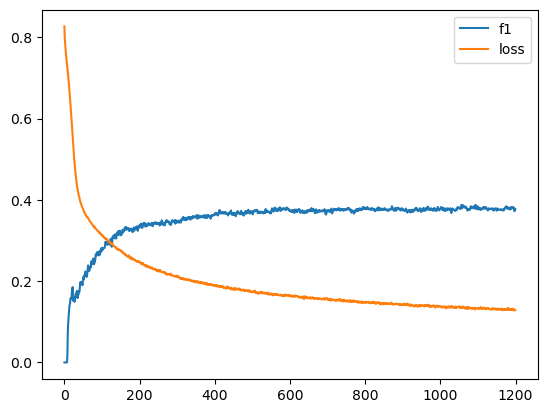

In [16]:
plt.plot(metrics, label="f1")
plt.plot(losses, label="loss")
plt.legend()
plt.show()

In [14]:

outputs = model.predict(df_inputs)
outputs = torch.where(outputs > 0.75, 1, 0)

print(classification_report(df_labels, outputs, target_names=df.columns[:-1]))

                            precision    recall  f1-score   support

                    Merged       1.00      0.94      0.97       988
   Self-direction: thought       1.00      0.98      0.99      1395
    Self-direction: action       1.00      0.00      0.01       247
               Stimulation       1.00      0.01      0.01       172
                  Hedonism       1.00      0.99      0.99      1512
               Achievement       1.00      0.65      0.78       610
          Power: dominance       1.00      0.95      0.98       625
          Power: resources       0.00      0.00      0.00       382
                      Face       1.00      0.99      0.99      2000
        Security: personal       1.00      0.98      0.99      1728
        Security: societal       1.00      0.90      0.95       568
                 Tradition       1.00      0.98      0.99      1177
         Conformity: rules       1.00      0.08      0.15       207
 Conformity: interpersonal       1.00      0.21

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
validation_inputs, validation_labels = load_data("datasets/validation_merged.csv")

outputs = model.predict(validation_inputs)
outputs = torch.where(outputs > 0.75, 1, 0)

print(classification_report(validation_labels, outputs, target_names=df.columns[:-1]))

# save classification report as CSV
report = classification_report(validation_labels, outputs, target_names=df.columns[:-1], output_dict=True)
report = pd.DataFrame(report).transpose()
report.to_csv("reports/validation_performance.csv")


                            precision    recall  f1-score   support

                    Merged       0.46      0.08      0.13       251
   Self-direction: thought       0.46      0.45      0.46       496
    Self-direction: action       0.00      0.00      0.00       138
               Stimulation       0.00      0.00      0.00       103
                  Hedonism       0.54      0.59      0.57       575
               Achievement       0.30      0.04      0.07       164
          Power: dominance       0.30      0.11      0.16       132
          Power: resources       0.00      0.00      0.00       130
                      Face       0.63      0.62      0.62       759
        Security: personal       0.42      0.27      0.33       488
        Security: societal       0.50      0.35      0.41       172
                 Tradition       0.52      0.24      0.33       455
         Conformity: rules       0.00      0.00      0.00        60
 Conformity: interpersonal       0.00      0.00

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\m